**CHURN PREDICTION IN BANKING INDUSTRY: INSIGHTS FROM ADVACED ANALYTICS AND MACHINE LEARNING**

**Import all required libraries**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as ms
from sklearn import model_selection, metrics  #to include metrics for evaluation # this used to be cross_validation
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, roc_auc_score,roc_curve
import matplotlib.pylab as plt
%matplotlib inline

In [ ]:
# Statistics Testing
from scipy import stats
from sklearn.neighbors import LocalOutlierFactor

## **FUNCTION SETUP**

In [ ]:
def dataInfo(X):
    print('='*10, 'DATA & FEATURE INFORMATION', '='*10)
    print(f'Data Rows: {X.shape[0]}')
    print(f'Data Columns: {X.shape[1]}')
    print(f'Duplicated Values: {X.duplicated().sum()}')
    missing_val = X.isnull().sum()
    missing_val_percentage = missing_val/len(X)*100
    data_type = X.dtypes
    unique_val = X.nunique()
    return pd.DataFrame({
        'Missing_val' : missing_val,
        'Missing_percentage' : missing_val_percentage,
        'Data_type' : data_type,
        'Unique_values' : unique_val
    }).sort_values('Missing_percentage',ascending=False)

In [ ]:
def dataOutlier(X, col):
    q1 = X[col].quantile(0.25) # Finding the first quartile
    q3 = X[col].quantile(0.75) # Finding the third quartile
    iqr_val = stats.iqr(X[col]) # Finding the interquartile range
    lower = q1 - (1.5*iqr_val) # Lower limit for detecting outliers in the data
    upper = q3 + (1.5*iqr_val) # Upper limit for detecting outliers in the data

    outlier_list = X[col].apply(lambda x: 'outlier' if x < lower or x > upper else 'not-outlier')
    print(f'outlier lower limit: {lower}\noutlier upper limit: {upper}')
    return outlier_list

In [ ]:
def lof_observation(df):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    df_num_cols = df.select_dtypes(include=numerics)
    df_outlier = df_num_cols.astype("float64")
    clf = LocalOutlierFactor(n_neighbors = 20, contamination = 0.1)
    clf.fit_predict(df_outlier)
    df_scores = clf.negative_outlier_factor_
    scores_df = pd.DataFrame(np.sort(df_scores))

    scores_df.plot(stacked=True, xlim = [0,20], color='r', title='Visualization of outliers according to the LOF method', style = '.-');                # first 20 observe
    th_val = np.sort(df_scores)[2]
    outliers = df_scores > th_val
    df = df.drop(df_outlier[~outliers].index)
    df.shape
    return df

In [ ]:
def dataUnique(X):
    for x in X.columns:
        print(f'========== {x} ==========')
        print(f'{X[x].unique()}\n') # Printing all the unique values in the columns

In [ ]:
def hist_boxplot(df, x_col, y_col=None, hue_col=None):
    color = '#F84030'
    if y_col is None:
        plt.figure(figsize=(10,10))
        plt.subplot(211)
        sns.boxplot(data=df, x=x_col, color=color)

        plt.subplot(212)
        sns.histplot(data=df, x=x_col, color=color)
        plt.tight_layout()
        plt.show()

    elif hue_col is None:
        plt.figure(figsize=(10,10))
        plt.subplot(211)
        sns.boxplot(data=df, x=x_col, y=y_col, color=color)

        plt.subplot(212)
        sns.histplot(data=df, x=x_col, y=y_col, color=color)
        plt.tight_layout()
        plt.show()

    else:
        plt.figure(figsize=(10,10))
        plt.subplot(211)
        sns.boxplot(data=df, x=x_col, y=y_col, hue=hue_col, color=color)

        plt.subplot(212)
        sns.histplot(data=df, x=x_col, y=y_col, hue=hue_col, color=color)
        plt.tight_layout()
        plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Read the data and view the top portion to see what we are dealing with.
data=pd.read_csv('/content/drive/My Drive/Files/Churn_Modeling.csv')
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [ ]:
data.count()

RowNumber          10000
CustomerId         10000
Surname            10000
CreditScore        10000
Geography          10000
Gender             10000
Age                10000
Tenure             10000
Balance            10000
NumOfProducts      10000
HasCrCard          10000
IsActiveMember     10000
EstimatedSalary    10000
Exited             10000
dtype: int64

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [ ]:
dataInfo(data)

========== DATA & FEATURE INFORMATION ==========
Data Rows: 10000
Data Columns: 14
Duplicated Values: 0


,Missing_val,Missing_percentage,Data_type,Unique_values
RowNumber,0,0.0,int64,10000
CustomerId,0,0.0,int64,10000
Surname,0,0.0,object,2932
CreditScore,0,0.0,int64,460
Geography,0,0.0,object,3
Gender,0,0.0,object,2
Age,0,0.0,int64,70
Tenure,0,0.0,int64,11
Balance,0,0.0,float64,6382
NumOfProducts,0,0.0,int64,4


In [ ]:
numerical = ['CreditScore',
             'Age',
             'Tenure',
             'Balance',
             'NumOfProducts',
             'EstimatedSalary']
categorical =['RowNumber',
              'CustomerId',
              'Surname',
              'Geography',
              'Gender',
              'HasCrCard',
              'IsActiveMember',
              'Exited']

In [ ]:
# data.describe(include='all')
data[numerical].describe().T

,count,mean,std,min,25%,50%,75%,max
CreditScore,10000.0,650.528800,96.653299,350.00,584.00,652.000,718.0000,850.00
Age,10000.0,38.921800,10.487806,18.00,32.00,37.000,44.0000,92.00
Tenure,10000.0,5.012800,2.892174,0.00,3.00,5.000,7.0000,10.00
Balance,10000.0,76485.889288,62397.405202,0.00,0.00,97198.540,127644.2400,250898.09
NumOfProducts,10000.0,1.530200,0.581654,1.00,1.00,1.000,2.0000,4.00
EstimatedSalary,10000.0,100090.239881,57510.492818,11.58,51002.11,100193.915,149388.2475,199992.48


In [ ]:
data[categorical].describe().T

,count,mean,std,min,25%,50%,75%,max
RowNumber,10000.0,5.000500e+03,2886.895680,1.0,2500.75,5000.5,7500.25,10000.0
CustomerId,10000.0,1.569094e+07,71936.186123,15565701.0,15628528.25,15690738.0,15753233.75,15815690.0
HasCrCard,10000.0,7.055000e-01,0.455840,0.0,0.00,1.0,1.00,1.0
IsActiveMember,10000.0,5.151000e-01,0.499797,0.0,0.00,1.0,1.00,1.0
Exited,10000.0,2.037000e-01,0.402769,0.0,0.00,0.0,0.00,1.0


In [ ]:
# data type of each columns feature variable
data.dtypes

RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

In [ ]:
data[data['Balance'].isna()==True] = 0
data['Tenure'].unique()

array([ 2,  1,  8,  7,  4,  6,  3, 10,  5,  9,  0])

In [ ]:
data.shape

(10000, 14)

In [ ]:
data.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

# **2. Data PreProcessing**

## **Deleting Unnecessary Information**

In [ ]:
# deleting the unnecessary columns (RowNumber, CustomerId, Surname)
data = data.drop(['RowNumber', 'CustomerId', 'Surname'],axis=1)

In [ ]:
data.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [ ]:
cont_cols = [i for i in data.columns if data[i].dtype in ['float64', 'int64']]
cont_cols

['CreditScore',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary',
 'Exited']

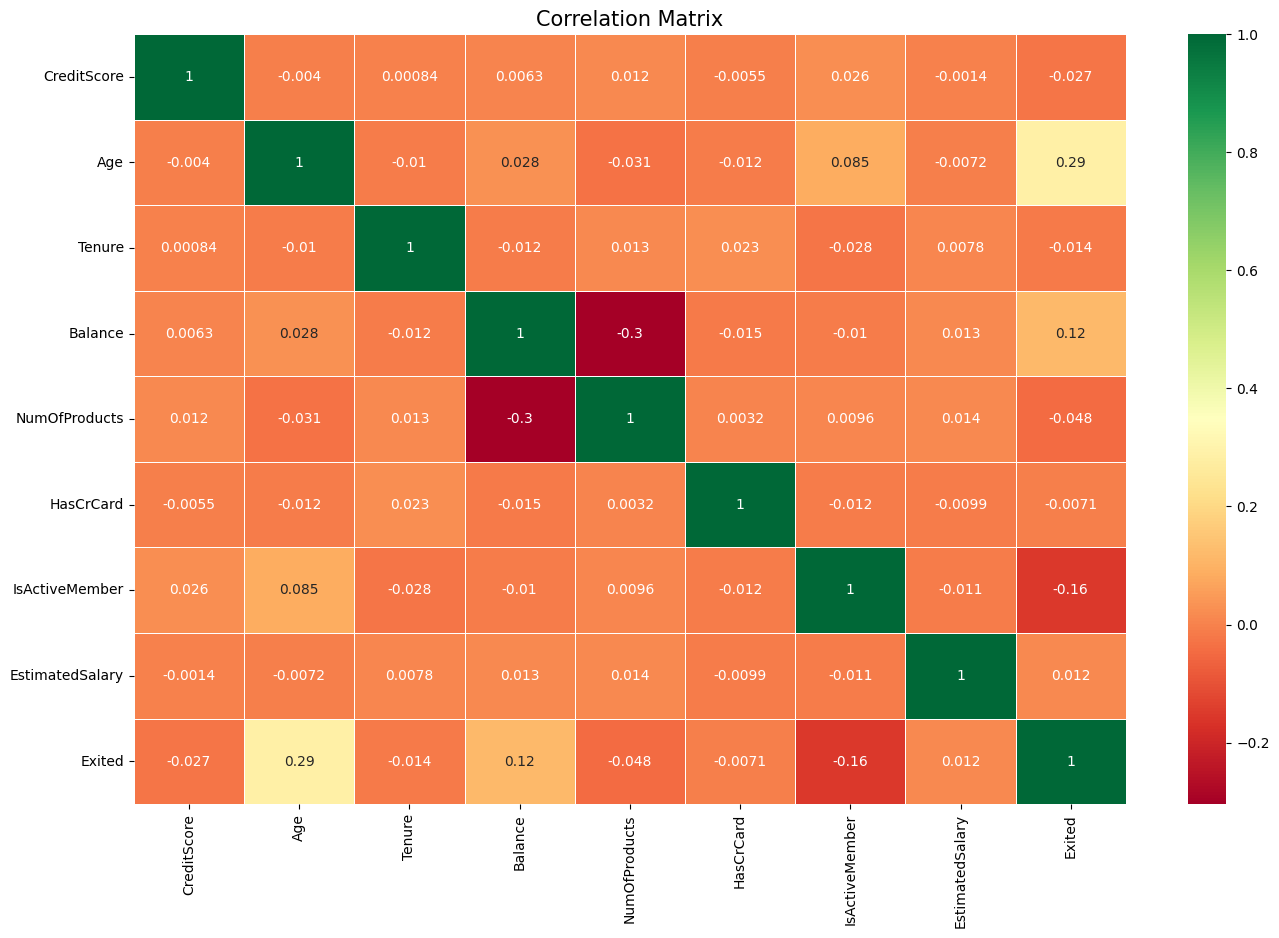

In [ ]:
plt.figure(figsize=(16,10))
sns.heatmap(data[cont_cols].corr(),annot=True,linewidths=.5, cmap="RdYlGn")
plt.title('Correlation Matrix',fontsize = 15)
plt.show()

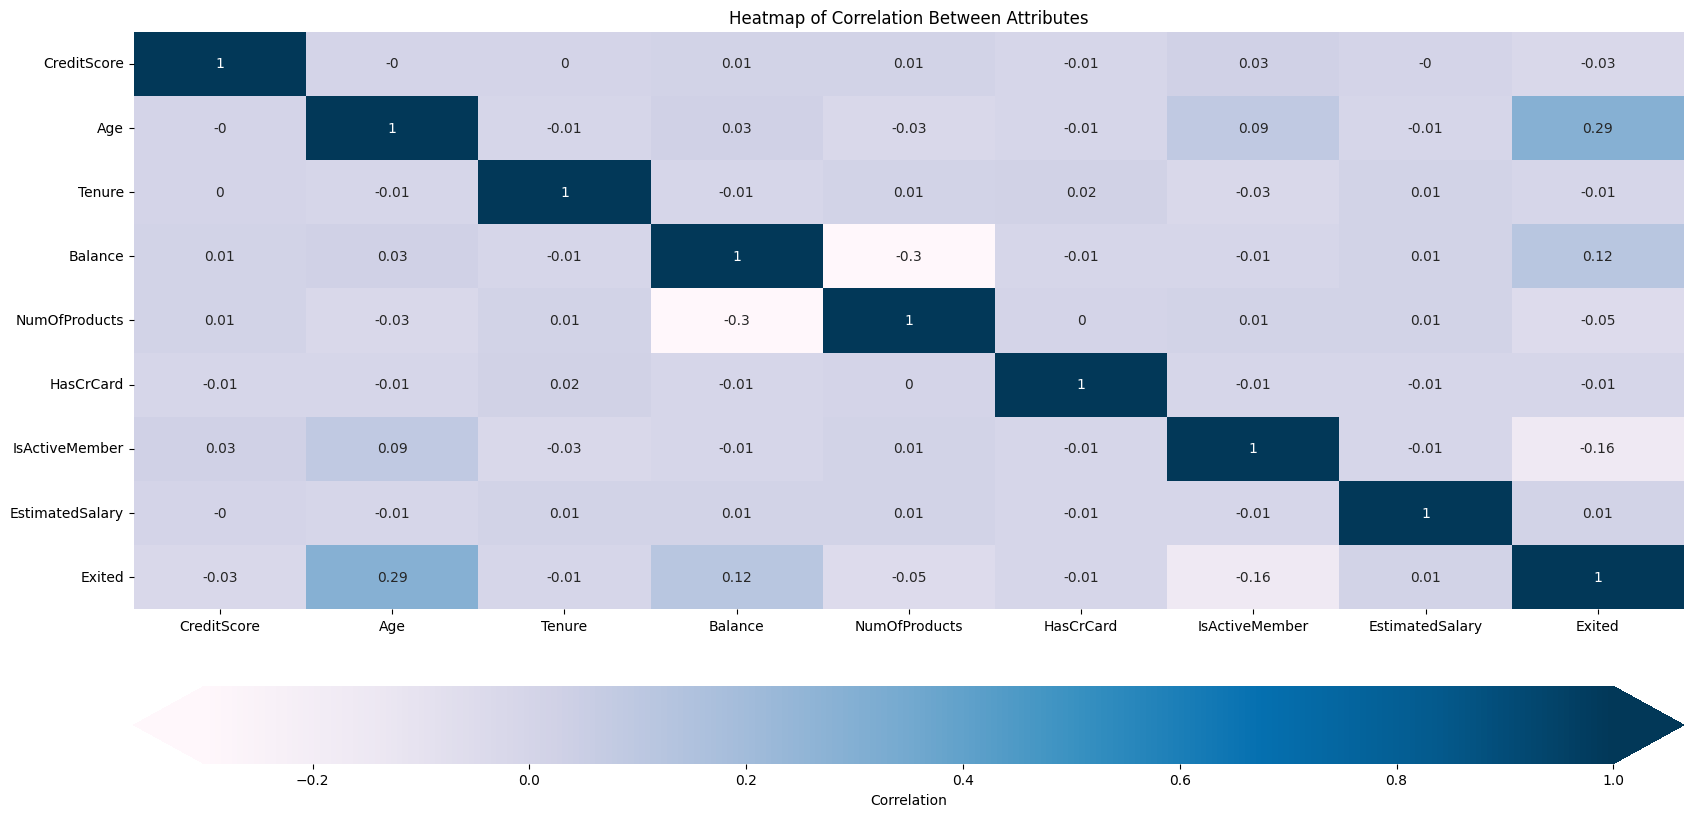

In [ ]:
# df with the correlation matrix
corr = round(data[cont_cols].corr(), 2)

# Setting up the figure and axes
fig, ax = plt.subplots(figsize=(20,10))
# Define custom color palette
custom_palette = ["#FF5733", "#C70039", "#900C3F", "#581845"]

# Plotting a heatmap of the correlation matrix(train_corr), with both numbers and colors indicating the correlations
sns.heatmap(
    # Specifying the data to be plotted
    data = corr,

    # # The mask is used to ensure duplicates are not shown
    # mask=np.triu(np.ones_like(corr, dtype=bool)),

    # Specifying the that the existing axes (ax) should be used
    ax=ax,

    # Specifying that the labels should be shown too.
    annot=True,

    # Customizing the  colorbar appearance
    cmap="PuBu",
    cbar_kws={"label": "Correlation", "orientation": "horizontal", "pad": .1, "extend": "both"}

)
# Customize the plot appearance
ax.set_title("Heatmap of Correlation Between Attributes");

# Observation:
    # There is not multicolinearity

## **Dealing with NULL or missing data**

In [ ]:
data.isnull().sum()

CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

## **Checking Data Health (Complete or Incomplete)**

<Axes: >

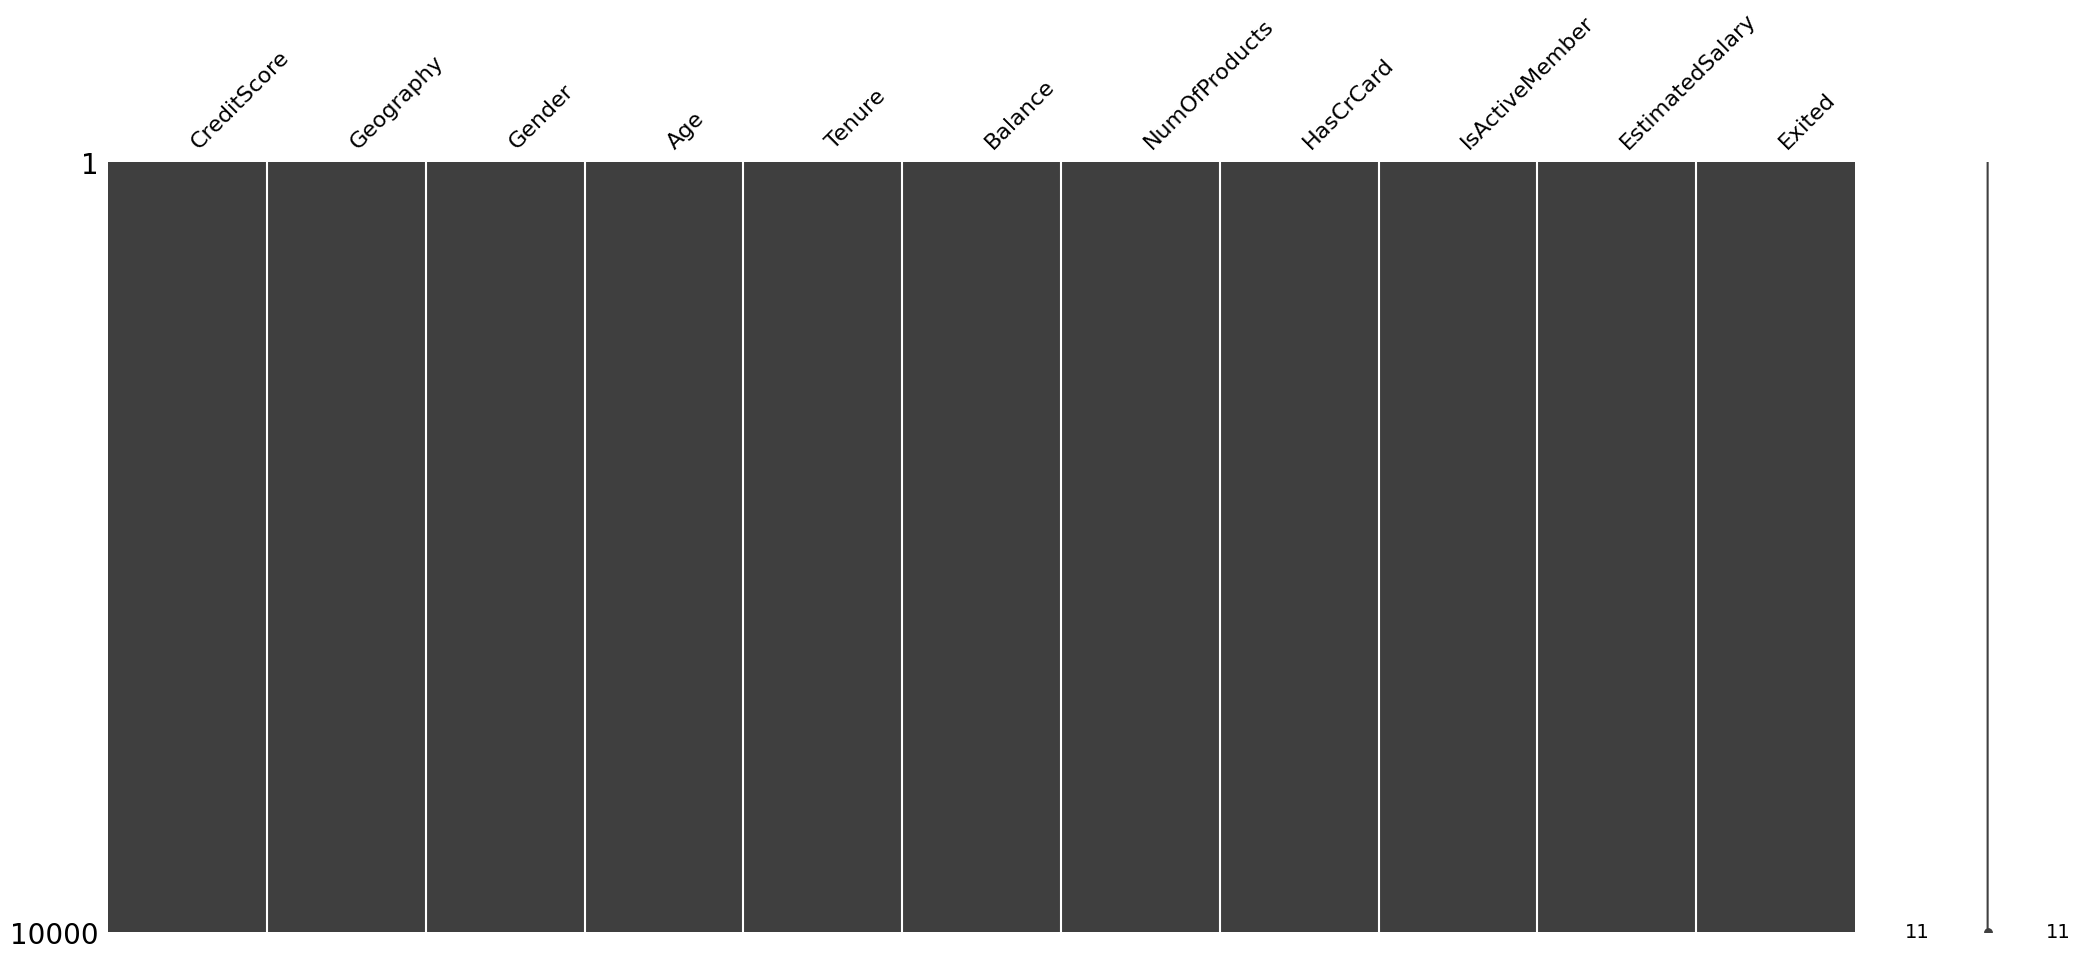

In [ ]:
# Check the data health. The sections should all be completely black indicating the data is complete.
ms.matrix(data)

## **Check/Remove Duplicates**

In [ ]:
# Check for duplicates
duplicate_rows = data.duplicated().sum()
print("\nNumber of Duplicate Rows:", duplicate_rows)


Number of Duplicate Rows: 0


In [ ]:
dataUnique(data)

========== CreditScore ==========
[619 608 502 699 850 645 822 376 501 684 528 497 476 549 635 616 653 587
 726 732 636 510 669 846 577 756 571 574 411 591 533 553 520 722 475 490
 804 582 472 465 556 834 660 776 829 637 550 698 585 788 655 601 656 725
 511 614 742 687 555 603 751 581 735 661 675 738 813 657 604 519 664 678
 757 416 665 777 543 506 493 652 750 729 646 647 808 524 769 730 515 773
 814 710 413 623 670 622 785 605 479 685 538 562 721 628 668 828 674 625
 432 770 758 795 686 789 589 461 584 579 663 682 793 691 485 650 754 535
 716 539 706 586 631 717 800 683 704 615 667 484 480 578 512 606 597 778
 514 525 715 580 807 521 759 516 711 618 643 671 689 620 676 572 695 592
 567 694 547 594 673 610 767 763 712 703 662 659 523 772 545 634 739 771
 681 544 696 766 727 693 557 531 498 651 791 733 811 707 714 782 775 799
 602 744 588 747 583 627 731 629 438 642 806 474 559 429 680 749 734 644
 626 649 805 718 840 630 654 762 568 613 522 737 648 443 640 540 460 593
 801 611 802 745 

# **3. Exploratory Data Analysis**

In [ ]:
# Explore how many churn data points we have.
print(len(data['Exited']))

10000


In [ ]:
# Explore how many customers in this dataset have exited.
data['Exited'].value_counts()

Exited
0    7963
1    2037
Name: count, dtype: int64

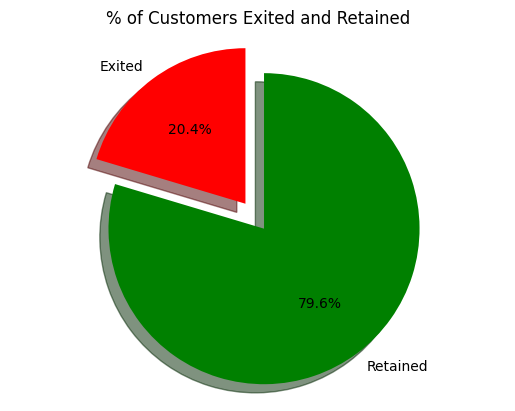

In [ ]:
# Pie chart to display the amount (%) of customers churned and the ones retained

labels = ['Exited', 'Retained']
sizes = [data.Exited[data['Exited'] == 1].count(), data.Exited[data['Exited'] == 0].count()]
explode = [0.1, 0]

# create and plot the pie chart

plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90, radius=0.5, colors=['r', 'g'], )
plt.title("% of Customers Exited and Retained", size = 12)
plt.axis('equal')
plt.show()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


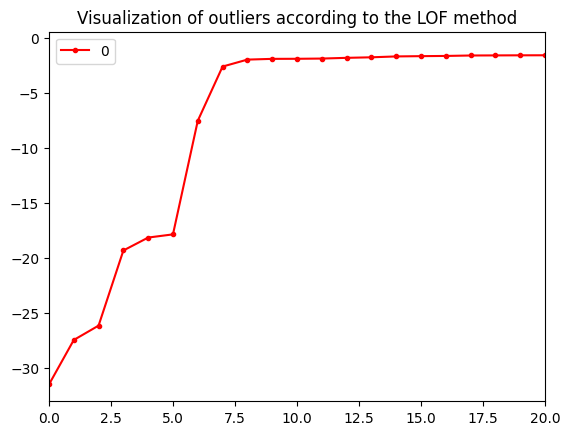

In [ ]:
lof_observation(data).head()

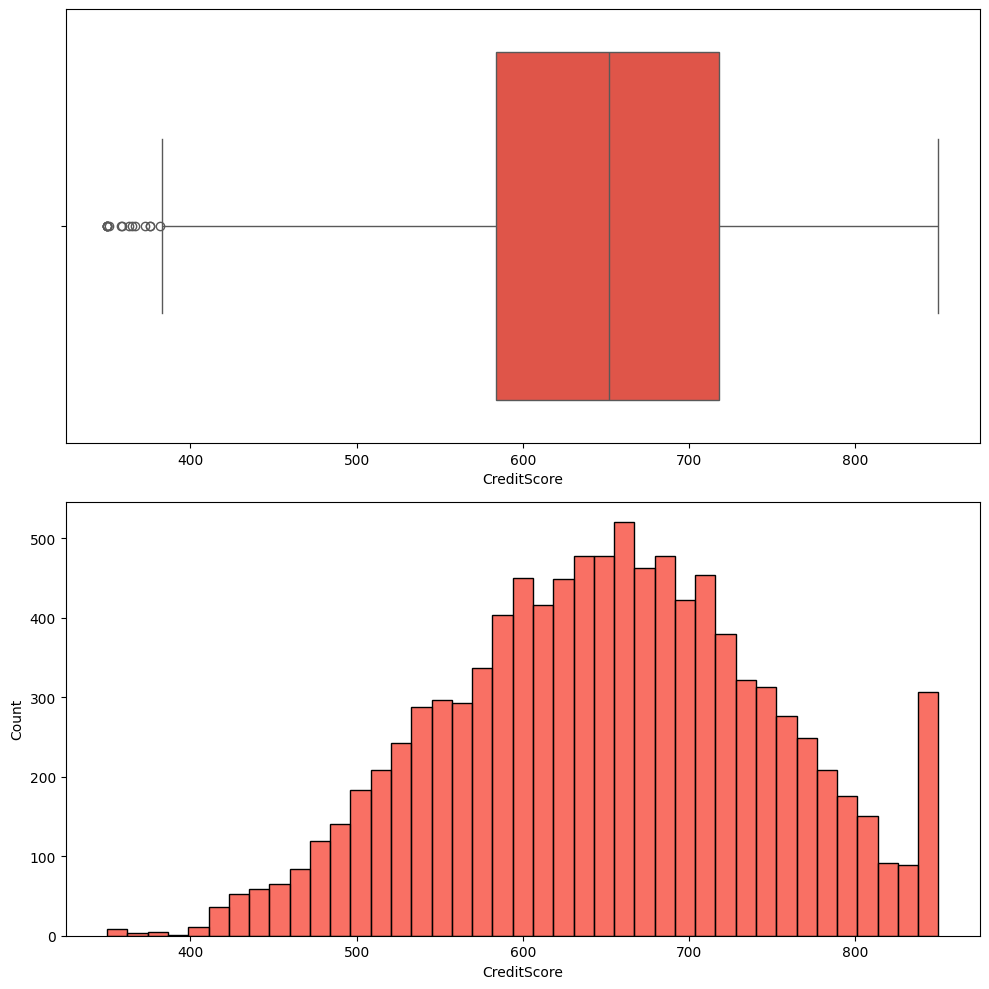

In [ ]:
hist_boxplot(data,'CreditScore')


### **Visualizing gender Distribution**

<ipython-input-34-360833c1d279>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=data['Gender'].value_counts().index,


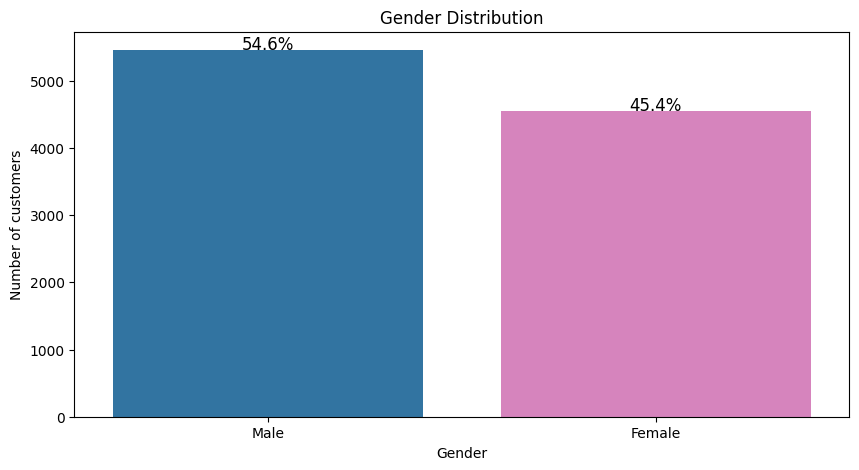

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
color_palette = sns.color_palette()
sns.barplot(x=data['Gender'].value_counts().index,
            y=data['Gender'].value_counts().values,
            palette=[color_palette[0], color_palette[6]]
            ).set(
                ylabel = 'Number of customers',
                xlabel = 'Gender',
                title = 'Gender Distribution'
            )

# Add percentage labels
gender_counts = data['Gender'].value_counts()
total_count = sum(gender_counts.values)
for i, count in enumerate(gender_counts.values):
    percentage = round(count / total_count * 100, 1)
    ax.text(i, count - 45, f'{percentage}%', ha='center', va='bottom', size=12)


# Observation:
  # There slightly more males than females

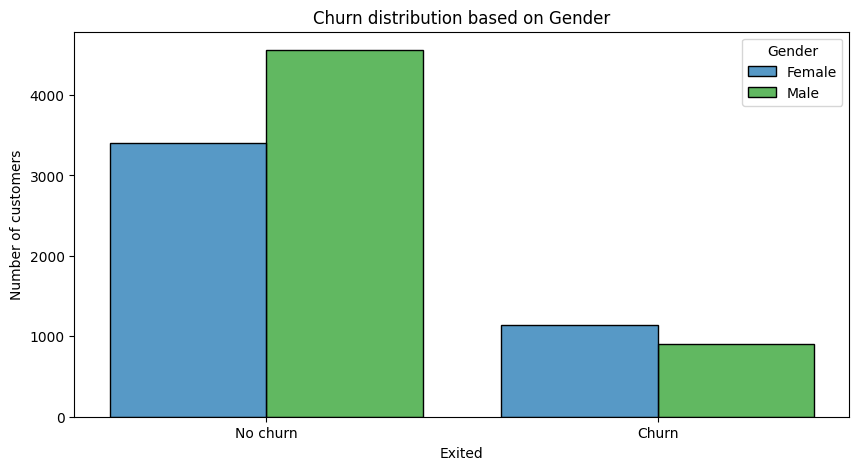

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
color_palette = sns.color_palette()
sns.histplot(data=data, x='Exited',
             bins=np.arange(3) - 0.5,
             hue='Gender',
             multiple='dodge',
             shrink=.8,
             legend= True,
             palette=[color_palette[0], color_palette[2]]
             ).set(
                xticks = range(2),
                xticklabels = ["No churn", "Churn"],
                ylabel = 'Number of customers',
                title = 'Churn distribution based on Gender'
             );
# Observation:
 # Slightly more males than females didn't exit which is expected since there were more males in the data
 # Slightly more females than males exited.

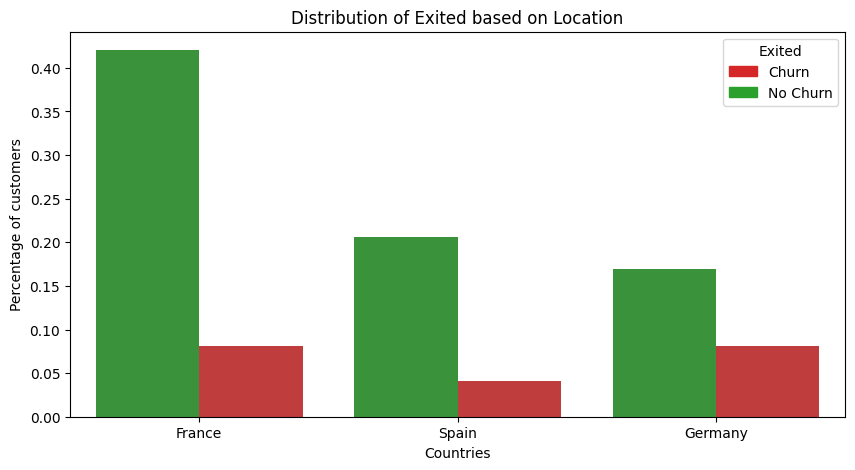

In [ ]:
location_df = pd.DataFrame(data[['Geography', 'Exited']].value_counts(normalize=True)).reset_index()
location_df_new = location_df.rename(columns={0: 'Proportion'})

color_palette = sns.color_palette()
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(data= location_df_new, x='Geography',
            y='proportion',
            hue='Exited',
            palette=[color_palette[2], color_palette[3]]
             ).set(
                xlabel = 'Countries',
                ylabel = 'Percentage of customers',
                title = 'Distribution of Exited based on Location'
             );

# Create custom legend handles and labels
legend_handles = [plt.Rectangle((0, 0), 1, 1, color=color_palette[3]), plt.Rectangle((0, 0), 1, 1, color=color_palette[2])]
legend_labels = ["Churn", "No Churn"]

# Set the legend
ax.legend(legend_handles, legend_labels, title='Exited');

# Observation:
 # The bank operates in 3 locations, France, Spain and Germany
 # France seems to be the location with most customers
 # France and Germany have almost the same amount of customers who exited.

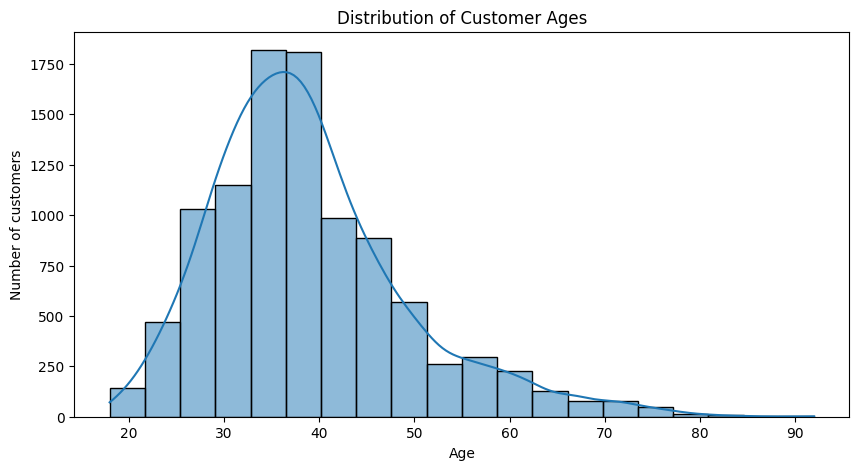

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
sns.histplot(data=data,
             x ='Age',
             bins=20,
             ax=ax,
             kde=True
             ).set(
                xlabel = 'Age',
                ylabel = 'Number of customers',
                title = 'Distribution of Customer Ages'
             );
# Observations
    # Majority of the customers are between the ages of 25 to50

In [ ]:
# Create age bins.
bins = [18, 30, 40, 50, 60, 100]  # Define the bin edges
labels = ['18-30', '31-40', '41-50', '51-60', '61+']  # Define the labels for each bin

data['Age Group'] = pd.cut(data['Age'], bins=bins, labels=labels, right=False)

# Print the modified DataFrame
data.tail()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Age Group
9995,771,France,Male,39,5,0.00,2,1,0,96270.64,0,31-40
9996,516,France,Male,35,10,57369.61,1,1,1,101699.77,0,31-40
9997,709,France,Female,36,7,0.00,1,0,1,42085.58,1,31-40
9998,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1,41-50
9999,792,France,Female,28,4,130142.79,1,1,0,38190.78,0,18-30


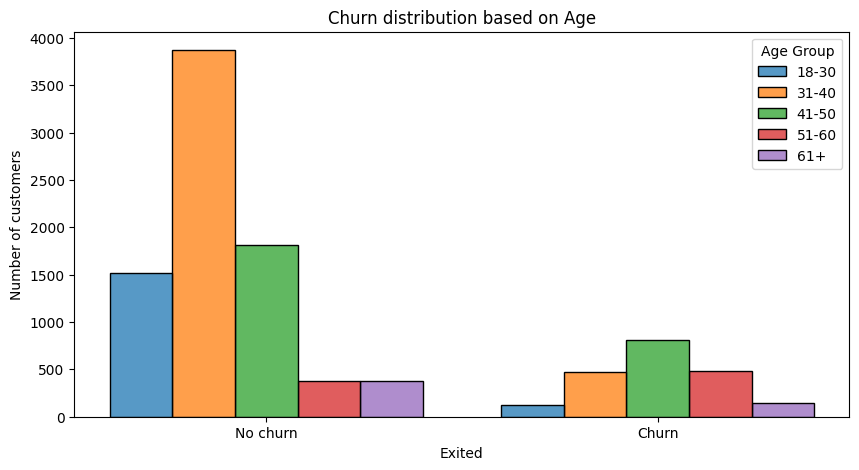

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
sns.histplot(data=data, x='Exited',
             bins=np.arange(3) - 0.5,
             hue='Age Group',
             multiple='dodge',
             shrink=.8,
             legend= True
             ).set(
                xticks = range(2),
                xticklabels = ["No churn", "Churn"],
                ylabel = 'Number of customers',
                title = 'Churn distribution based on Age'
             );
# Observation:
   # Most accounts are owned by people with less than 50 years. Especially 31-40 years
   # Customers of ages 41-50 have the highest churn rate

<ipython-input-127-3364e2982d4f>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='HasCrCard', y='Exited', data=data, palette='Set1', ax=ax[0][0])
<ipython-input-127-3364e2982d4f>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='IsActiveMember', y='Exited', data=data, palette='Set1', ax=ax[0][1])
<ipython-input-127-3364e2982d4f>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='NumOfProducts', y='Exited', data=data, palette='Set1', ax=ax[1][0])


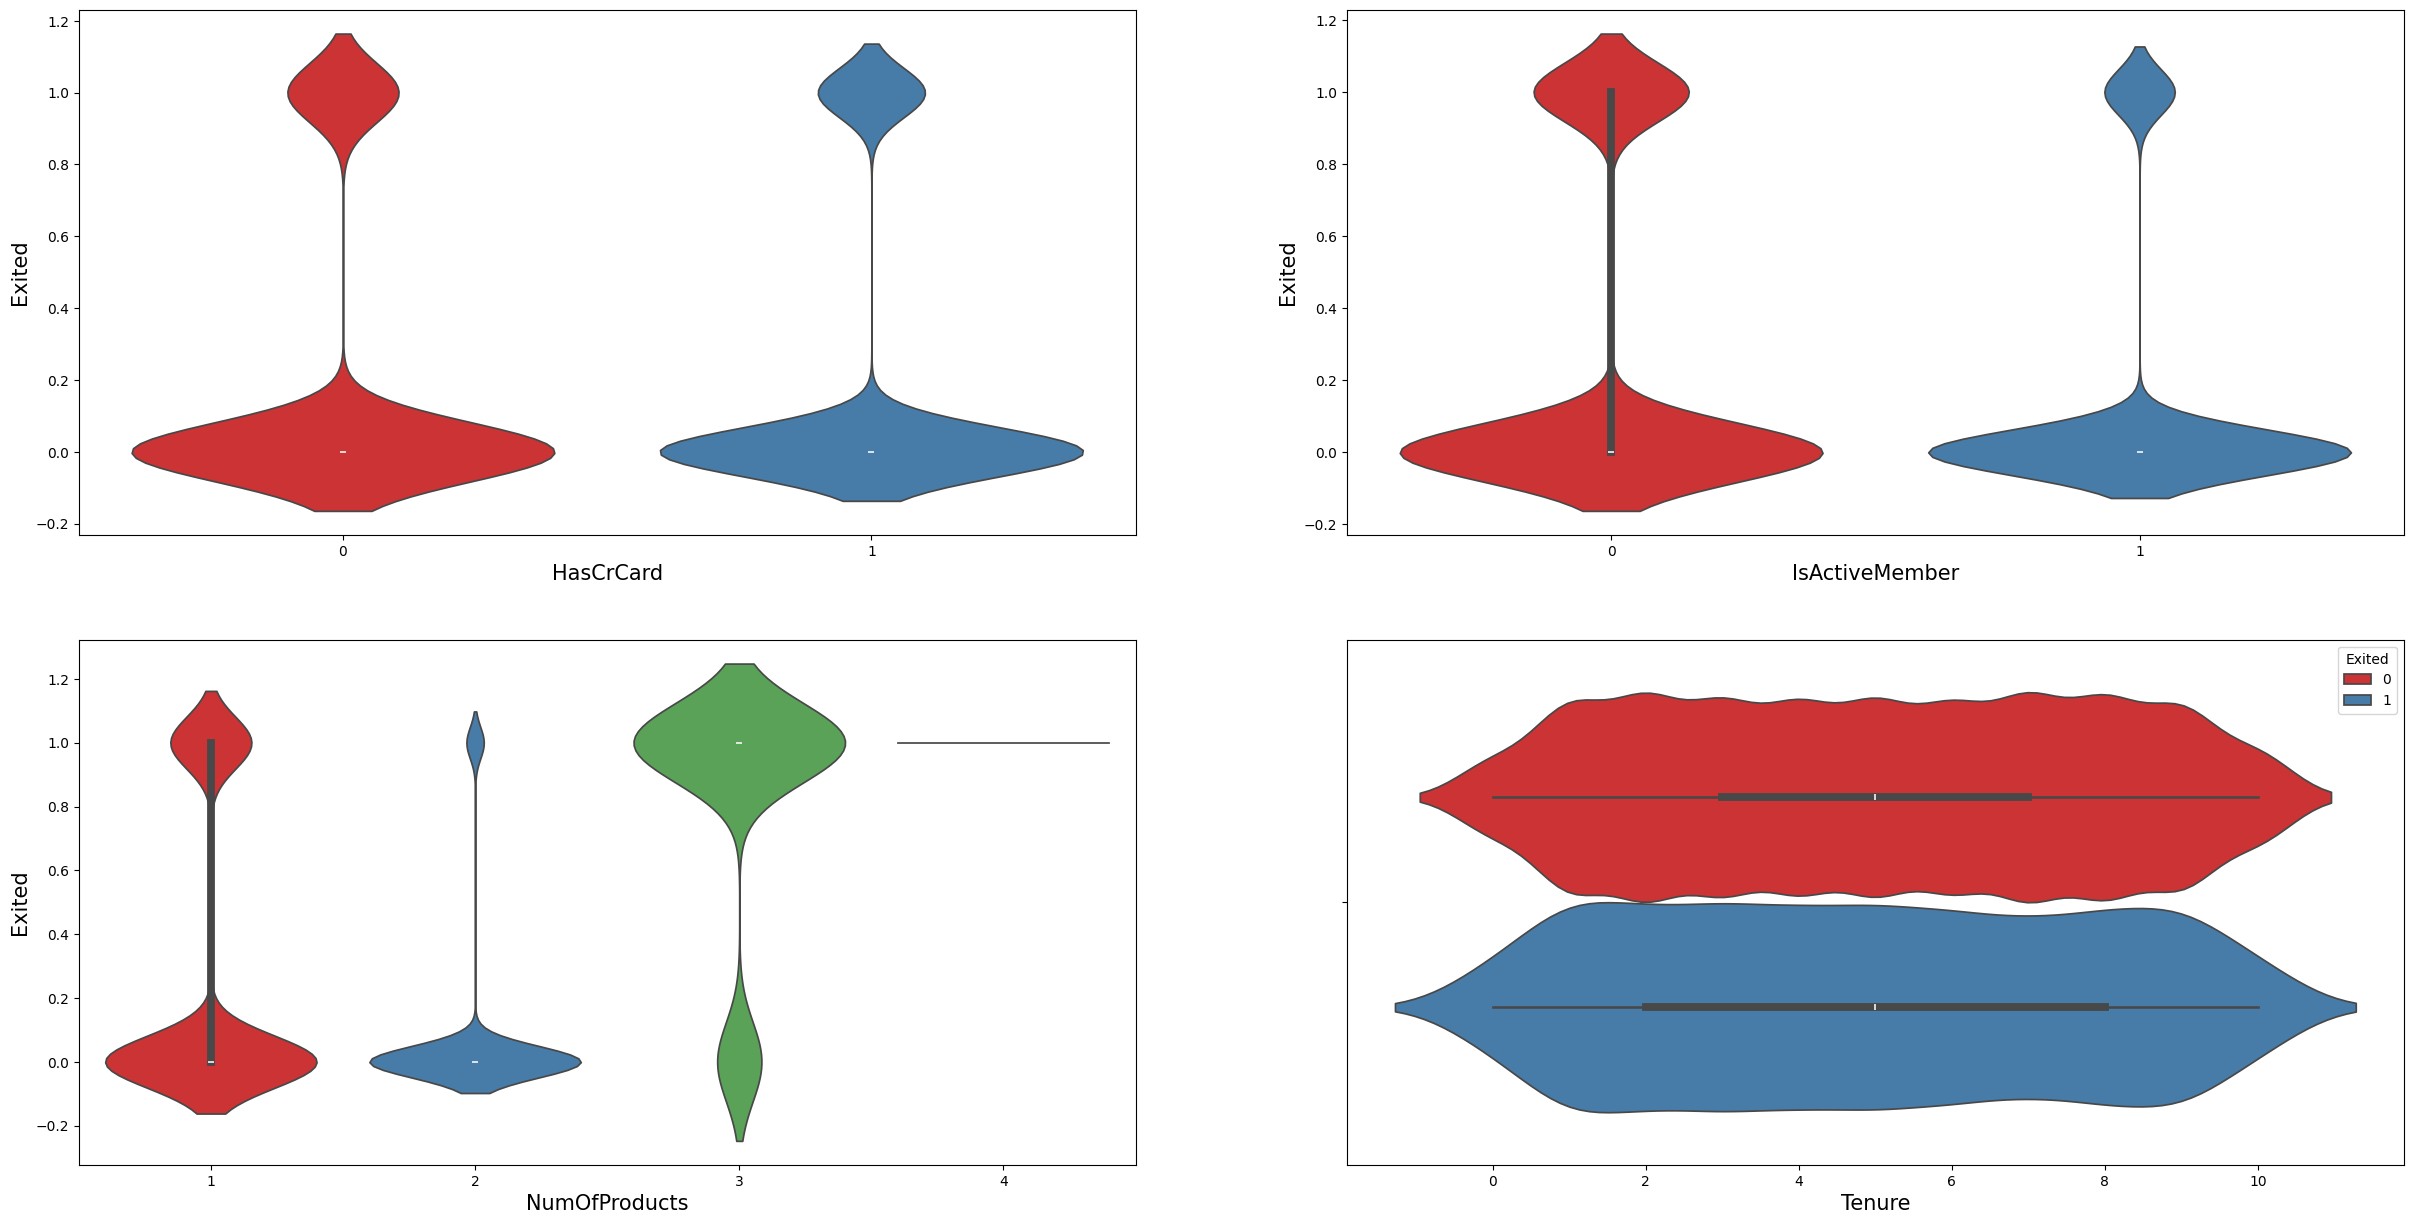

In [ ]:
# Count violin plots to map the dependence of 'Exited' column on categorical features

fig, ax = plt.subplots(2, 2, figsize=(30, 15))

# sns.countplot(x='Geography', hue='Exited', data=data, palette='Set1', ax=ax[0][0])
# sns.countplot(x='Gender', hue='Exited', data=data, palette='Set1', ax=ax[0][1])
sns.violinplot(x='HasCrCard', y='Exited', data=data, palette='Set1', ax=ax[0][0])
sns.violinplot(x='IsActiveMember', y='Exited', data=data, palette='Set1', ax=ax[0][1])
sns.violinplot(x='NumOfProducts', y='Exited', data=data, palette='Set1', ax=ax[1][0])
sns.violinplot(x='Tenure', hue='Exited', data=data, palette='Set1', ax=ax[1][1])

for row in ax:
    for col in row:
       col.set_xlabel(col.get_xlabel(), fontsize=15)
       col.set_ylabel(col.get_ylabel(), fontsize=15)
plt.show()

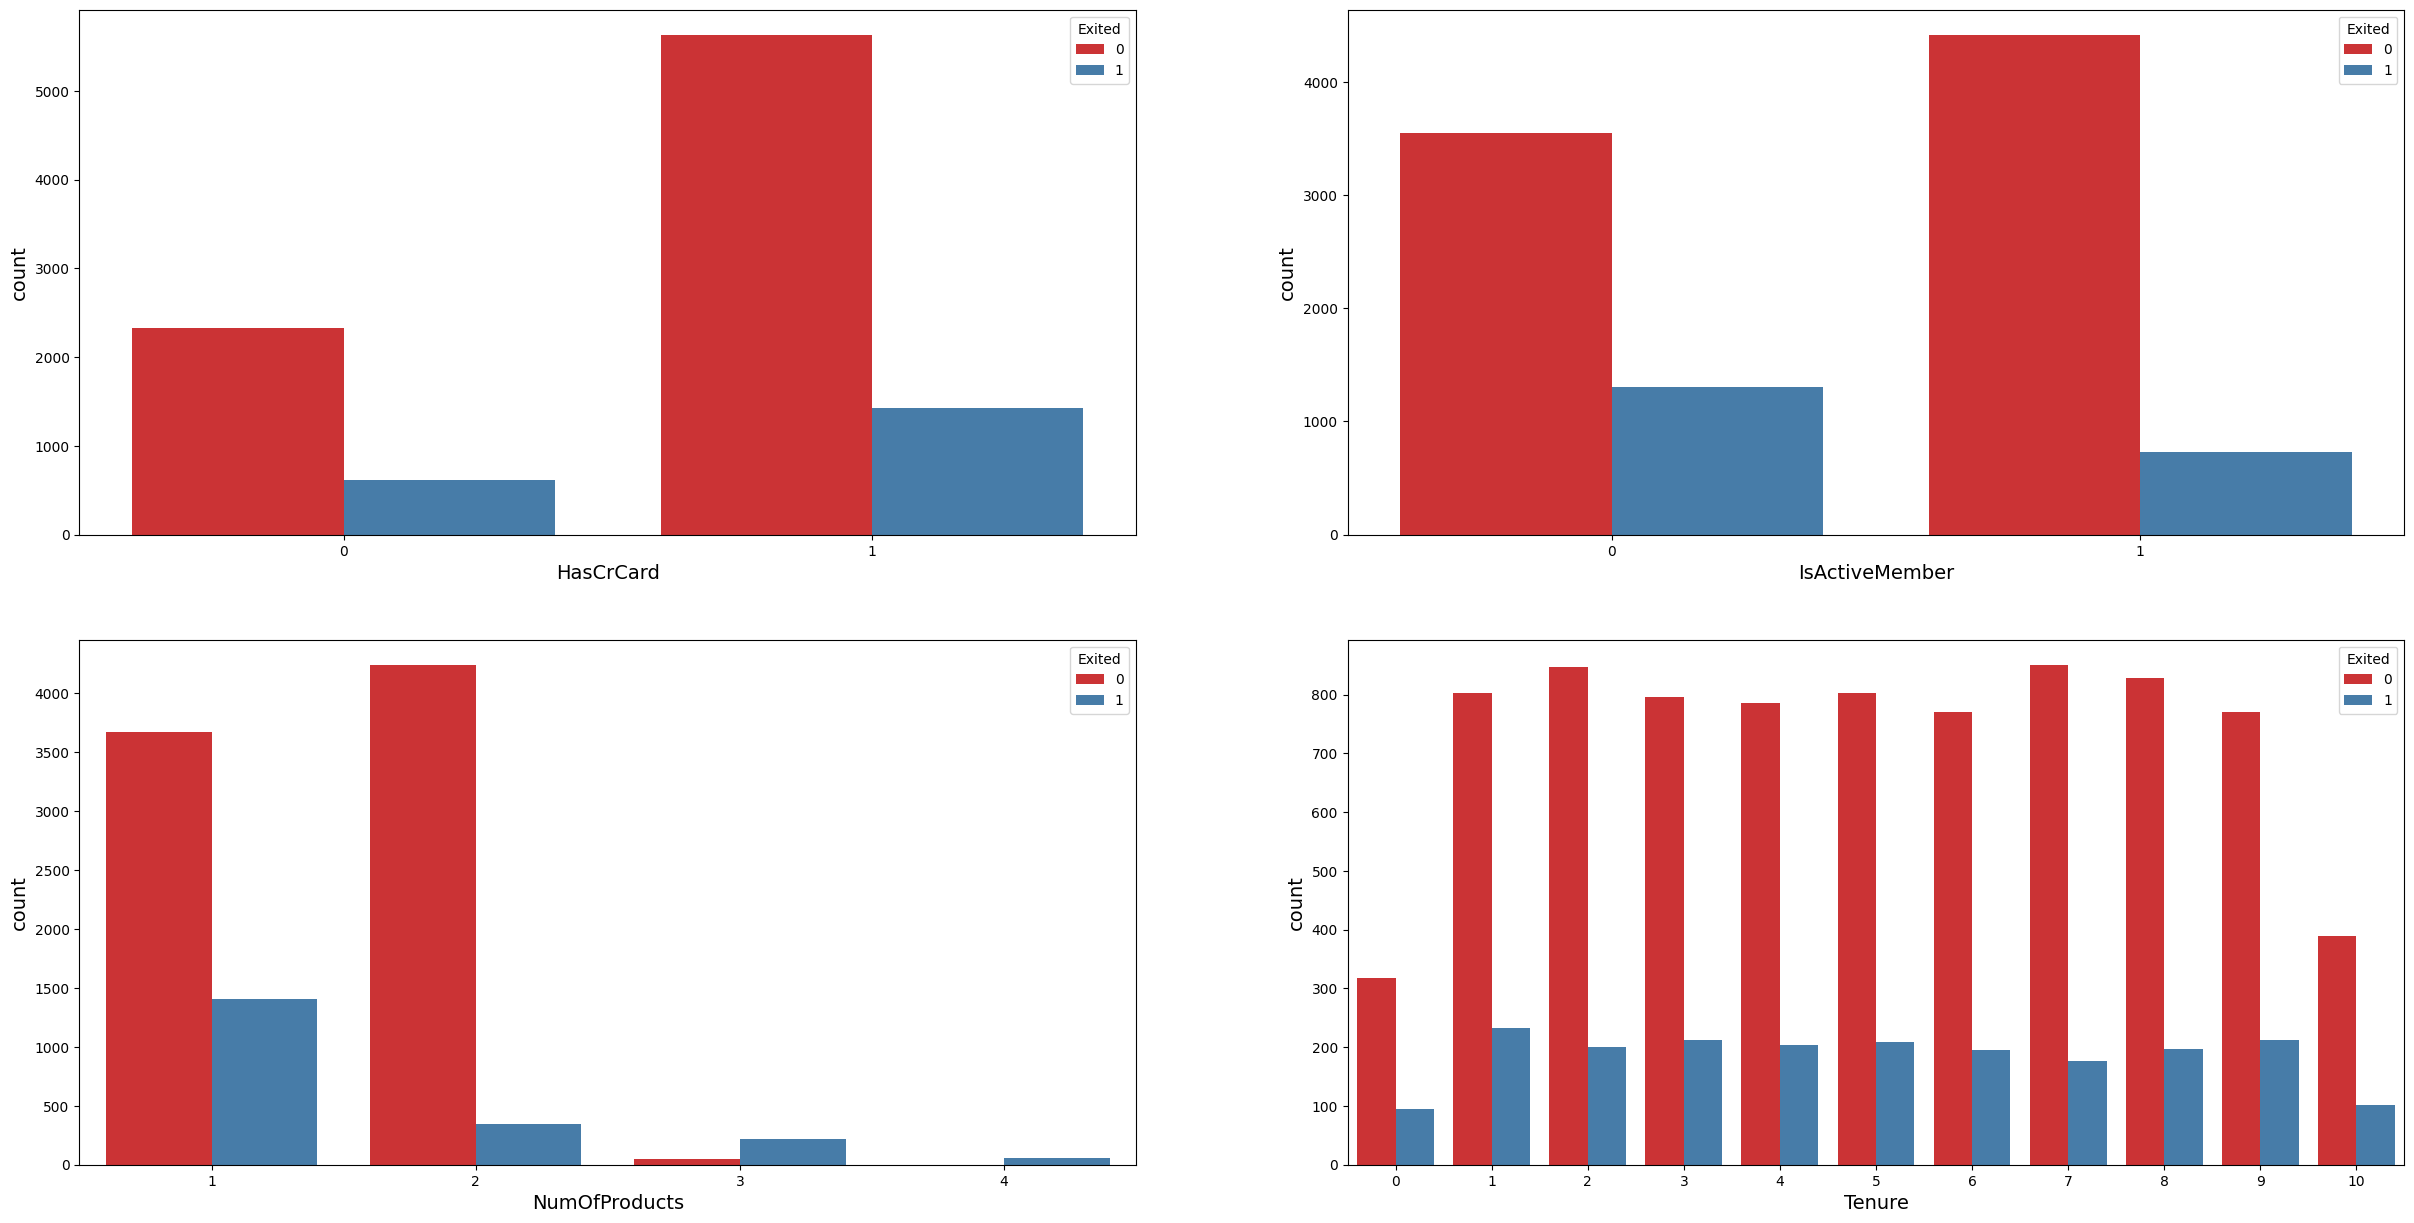

In [ ]:
# Count column plots to map the dependence of 'Exited' column on categorical features

fig, ax = plt.subplots(2, 2, figsize=(30, 15))

# sns.countplot(x='Geography', hue='Exited', data=data, palette='Set1', ax=ax[0][0])
# sns.countplot(x='Gender', hue='Exited', data=data, palette='Set1', ax=ax[0][1])
sns.countplot(x='HasCrCard', hue='Exited', data=data, palette='Set1', ax=ax[0][0])
sns.countplot(x='IsActiveMember', hue='Exited', data=data, palette='Set1', ax=ax[0][1])
sns.countplot(x='NumOfProducts', hue='Exited', data=data, palette='Set1', ax=ax[1][0])
sns.countplot(x='Tenure', hue='Exited', data=data, palette='Set1', ax=ax[1][1])

for row in ax:
    for col in row:
       col.set_xlabel(col.get_xlabel(), fontsize=14)
       col.set_ylabel(col.get_ylabel(), fontsize=14)
plt.show()


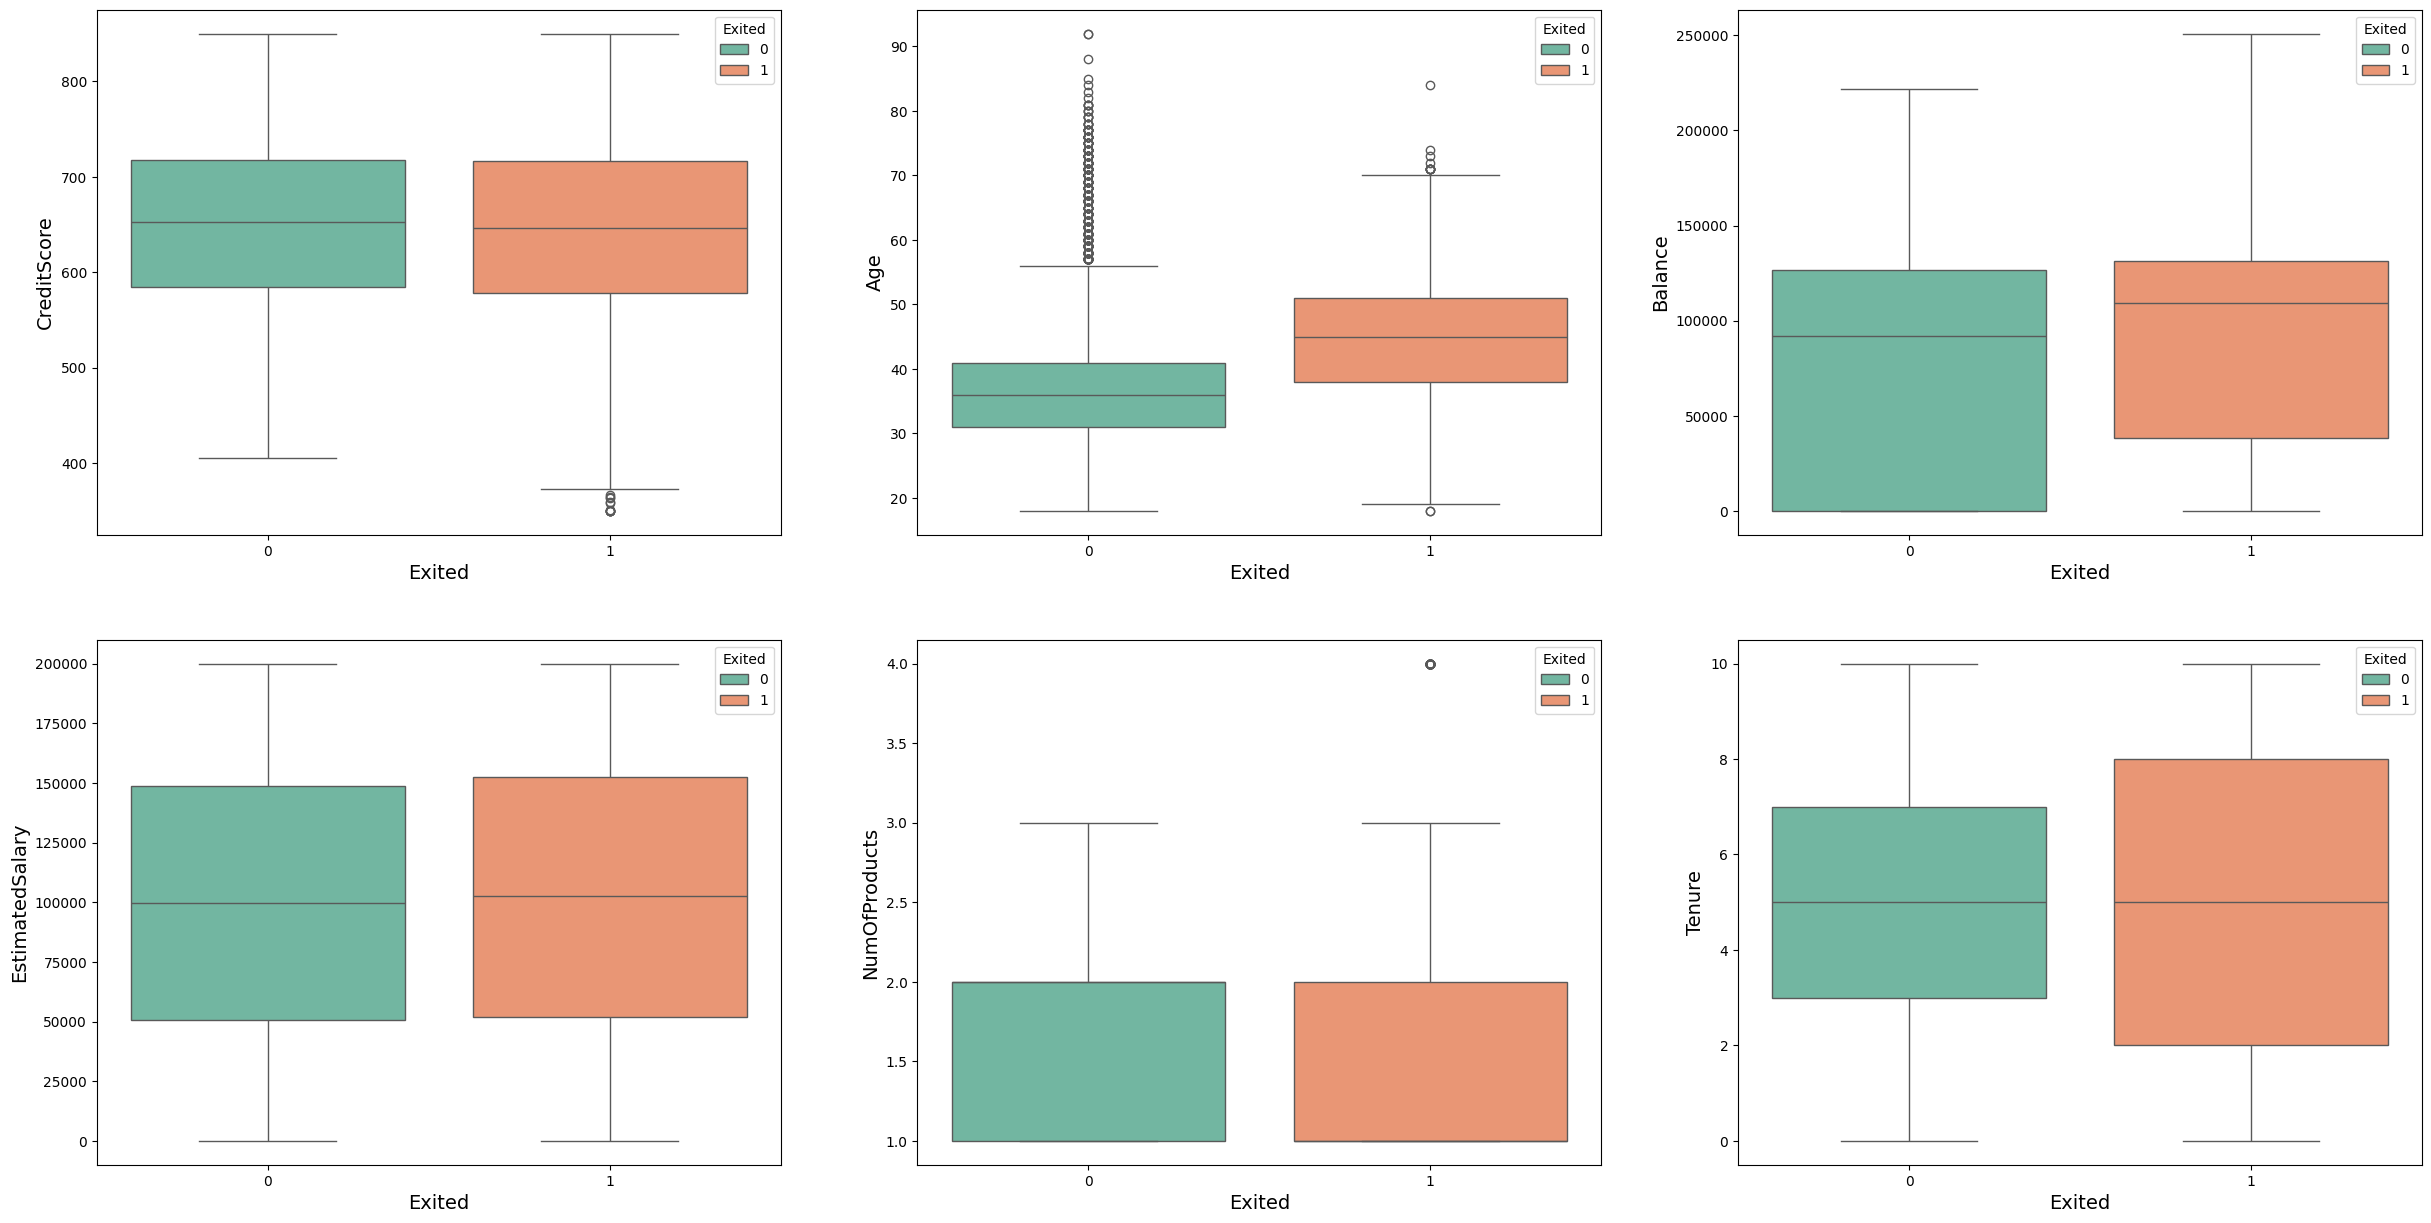

In [ ]:
# Count column plots to map the dependence of 'Exited' column on continuous and numerical features

fig, ax = plt.subplots(2, 3, figsize=(30, 15))

sns.boxplot(data=data, x='Exited', y='CreditScore', hue='Exited', ax=ax[0][0],palette="Set2")
sns.boxplot(data=data, x='Exited', y='Age', hue='Exited', ax=ax[0][1] ,palette="Set2")
sns.boxplot(data=data, x='Exited', y='Balance', hue='Exited', ax=ax[0][2],palette="Set2")
sns.boxplot(data=data, x='Exited', y='EstimatedSalary', hue='Exited', ax=ax[1][0],palette="Set2")
sns.boxplot(data=data, x='Exited', y='NumOfProducts', hue='Exited', ax=ax[1][1],palette="Set2")
sns.boxplot(data=data, x='Exited', y='Tenure', hue='Exited', ax=ax[1][2],palette="Set2")

 # Set font size for x-axis and y-axis tick labels for each subplot
for row in ax:
    for col in row:
       col.set_xlabel(col.get_xlabel(), fontsize=14)
       col.set_ylabel(col.get_ylabel(), fontsize=14)
plt.show()

# **4. Data Preparation**

## **Checking For Outliers**

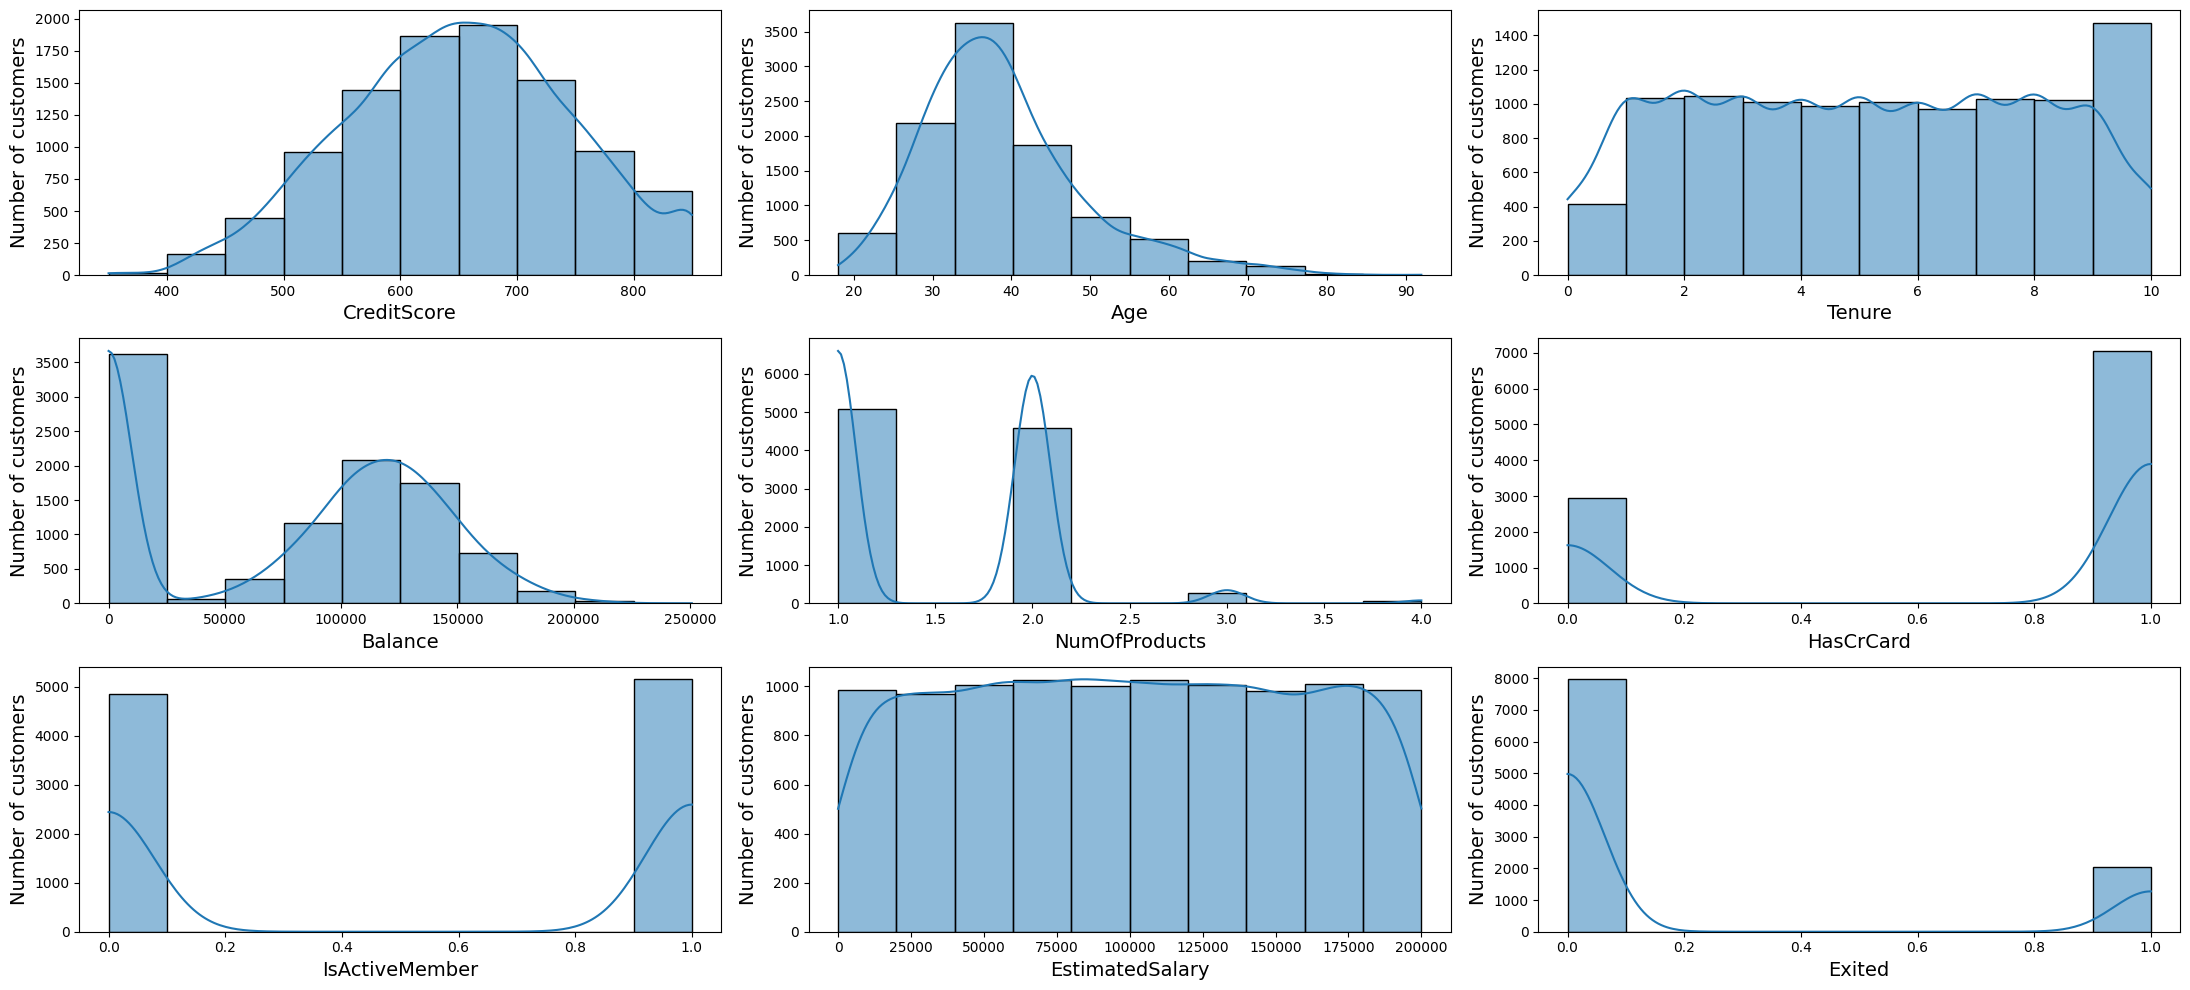

In [ ]:

fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(22,10))
for i, col in enumerate(cont_cols):
     ax = axes[i//3][i%3]
     sns.histplot(data[col], bins=10 ,kde=True, ax=ax)
     ax.set_xlabel(col)
     ax.set_ylabel("Number of customers")
     ax.set_xlabel(ax.get_xlabel(), fontsize=14)
     ax.set_ylabel(ax.get_ylabel(), fontsize=14)
fig.set_tight_layout(True);
plt.show()
# Observation:
     # The data has no outliers

## **Encloding Categorical Data**

In [ ]:
#Encoding the categorical data into numeric
dataEN =data.iloc[:, :-1]
dataEN = data.drop(columns=['Age Group'])

# dataEN = pd.get_dummies(dataEN,drop_first = True)
dataEN = pd.get_dummies(dataEN,columns = ['Geography','Gender'])
dataEN.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,True,False,False,True,False
1,608,41,1,83807.86,1,0,1,112542.58,0,False,False,True,True,False
2,502,42,8,159660.80,3,1,0,113931.57,1,True,False,False,True,False
3,699,39,1,0.00,2,0,0,93826.63,0,True,False,False,True,False
4,850,43,2,125510.82,1,1,1,79084.10,0,False,False,True,True,False


<Axes: xlabel='Exited', ylabel='count'>

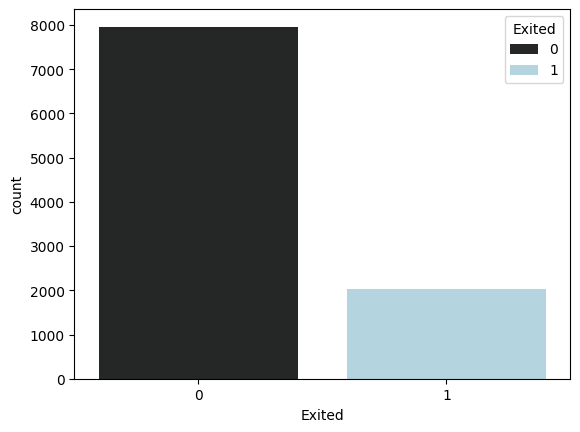

In [ ]:

sns.countplot(x='Exited', hue='Exited', data=data, palette='dark:lightblue')

# **Modelling**

In [ ]:
##Setting X independent variables and Y as target variable
X = dataEN.drop('Exited',axis=1)
# X = dataEN.drop(columns=['Exited','Age Group'])
y = dataEN['Exited']


## **Handling Imbalanced Data with SMOTE**

In [ ]:
from imblearn.over_sampling import SMOTE
X_res, y_res = SMOTE().fit_resample(X,y)
y_res.value_counts()

Exited
1    7963
0    7963
Name: count, dtype: int64

<ipython-input-60-56fe6a3ea50b>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_res ,palette='dark:lightblue')


<Axes: xlabel='Exited', ylabel='count'>

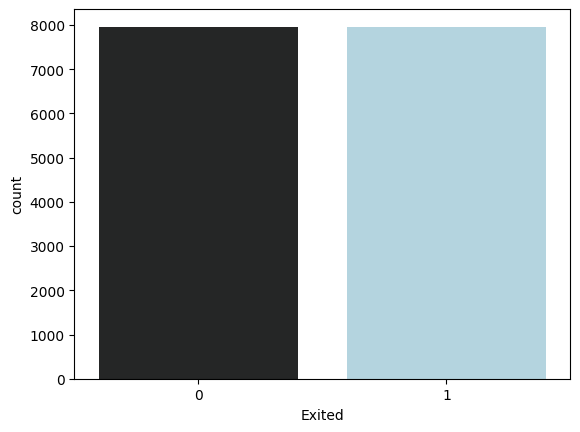

In [ ]:
sns.countplot(x=y_res ,palette='dark:lightblue')
# sns.countplot(x='Exited', hue='Exited', data=y_res, palette='dark:lightblue')

### **Splitting The Dataset into Training Set and Test Set**

In [ ]:
from sklearn.model_selection import train_test_split
# before resampling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=47)
#after resampling
X_train_res, X_test_res, y_train_res, y_test_res = train_test_split(X_res, y_res, test_size=0.2, random_state=47)

In [ ]:
df_sampling = pd.concat([pd.DataFrame(X_res), pd.Series(y_res)], axis=1)
# df_sampling.columns = dataEN.drop(columns=['Age Group']).columns
df_sampling.columns = dataEN.columns
df_sampling.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,True,False,False,True,False,1
1,608,41,1,83807.86,1,0,1,112542.58,False,False,True,True,False,0
2,502,42,8,159660.80,3,1,0,113931.57,True,False,False,True,False,1
3,699,39,1,0.00,2,0,0,93826.63,True,False,False,True,False,0
4,850,43,2,125510.82,1,1,1,79084.10,False,False,True,True,False,0


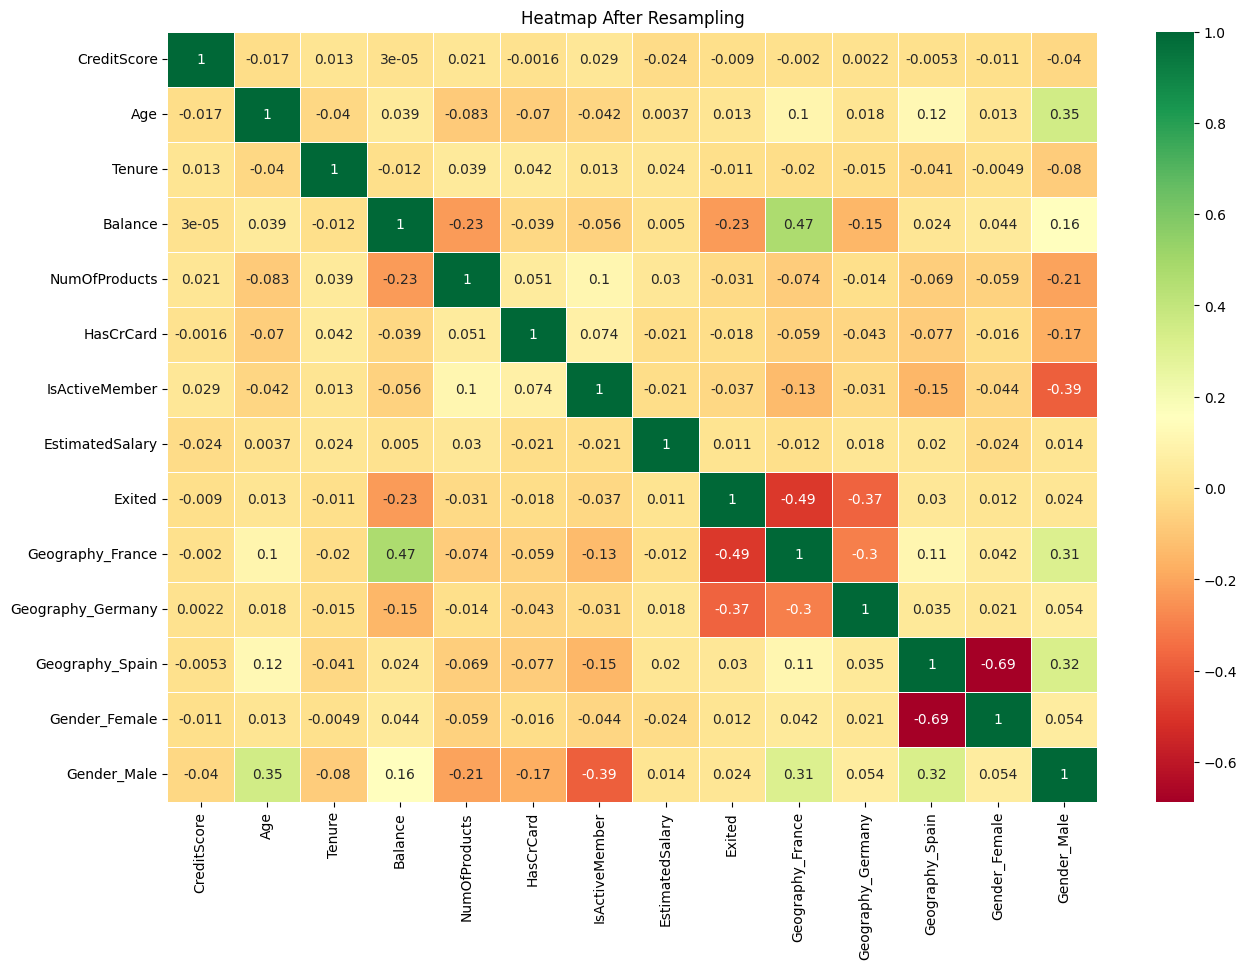

In [ ]:
plt.figure(figsize=(15,10))
sns.heatmap(df_sampling.corr(),annot=True,linewidths=.5, cmap="RdYlGn")
plt.title('Heatmap After Resampling')
plt.show()

### **Feature Scaling**

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
#before resampling
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

#after resampling
X_train_res = sc.fit_transform(X_train_res)
X_test_res = sc.transform(X_test_res)

# **1. Decison Tree**

In [ ]:
decision_tree = DecisionTreeClassifier(criterion='entropy', random_state=42)

decision_tree.fit(X_train, y_train)
y_pred  = decision_tree.predict(X_test)

# y_test_pred = SMOTE_decision_tree.predict(X_test)
# y_train_pred = SMOTE_decision_tree.predict(X_train)

print('**************************Before SMOTE*************************')
print(classification_report(y_test, y_pred))

decision_tree.fit(X_train_res, y_train_res)
y_pred_res = decision_tree.predict(X_test_res)
print('**************************After SMOTE*************************')
print(classification_report(y_test_res, y_pred_res))


**************************Before SMOTE*************************
              precision    recall  f1-score   support

           0       0.87      0.86      0.86      1577
           1       0.50      0.51      0.50       423

    accuracy                           0.79      2000
   macro avg       0.68      0.69      0.68      2000
weighted avg       0.79      0.79      0.79      2000

**************************After SMOTE*************************
              precision    recall  f1-score   support

           0       0.83      0.83      0.83      1627
           1       0.82      0.83      0.83      1559

    accuracy                           0.83      3186
   macro avg       0.83      0.83      0.83      3186
weighted avg       0.83      0.83      0.83      3186



# **2. Logistic Regression**

In [ ]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

# y_test_pred = lr.predict(X_test)
# y_train_pred = lr.predict(X_train_resampled)

y_pred_lg = lr.predict(X_test)


print('***************************Before SMOTE********************************')
print(classification_report(y_test, y_pred_lg))

lr.fit(X_train_res, y_train_res)
y_pred_lg_res = lr.predict(X_test_res)
print('***************************After SMOTE********************************')
print(classification_report(y_test_res, y_pred_lg_res))


***************************Before SMOTE********************************
              precision    recall  f1-score   support

           0       0.82      0.97      0.89      1577
           1       0.62      0.21      0.32       423

    accuracy                           0.81      2000
   macro avg       0.72      0.59      0.60      2000
weighted avg       0.78      0.81      0.77      2000

***************************After SMOTE********************************
              precision    recall  f1-score   support

           0       0.80      0.90      0.84      1627
           1       0.88      0.76      0.81      1559

    accuracy                           0.83      3186
   macro avg       0.84      0.83      0.83      3186
weighted avg       0.84      0.83      0.83      3186



# **3. KNN(KNeighborsClassifier)**

In [ ]:
knn = KNeighborsClassifier(n_neighbors=3)


knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
# y_test_pred = knn.predict(X_test)
# y_train_pred = knn.predict(X_train_resampled)

print('**************************Before SMOTE******************************')
print(classification_report(y_test, y_pred_knn))

knn.fit(X_train_res, y_train_res)
y_pred_knn_res = knn.predict(X_test_res)
print('***************************After SMOTE************************')
print(classification_report(y_test_res, y_pred_knn_res))


**************************Before SMOTE******************************
              precision    recall  f1-score   support

           0       0.86      0.93      0.89      1577
           1       0.61      0.43      0.50       423

    accuracy                           0.82      2000
   macro avg       0.73      0.68      0.70      2000
weighted avg       0.80      0.82      0.81      2000

***************************After SMOTE************************
              precision    recall  f1-score   support

           0       0.84      0.87      0.85      1627
           1       0.86      0.83      0.84      1559

    accuracy                           0.85      3186
   macro avg       0.85      0.85      0.85      3186
weighted avg       0.85      0.85      0.85      3186



# **4. SVM**

In [ ]:
from sklearn import svm
svm = svm.SVC()

svm.fit(X_train, y_train)
y_pred_svm =svm.predict(X_test)

# y_test_pred=svm.predict(X_test)
# y_train_pred = knn.predict(X_train_resampled)

print('***************************Before SMOTE***************************')
print(classification_report(y_test, y_pred_svm))

svm.fit(X_train_res, y_train_res)
y_pred_svm_res =svm.predict(X_test_res)
print('***************************After SMOTE*****************************')
print(classification_report(y_test_res, y_pred_svm_res))


***************************Before SMOTE***************************
              precision    recall  f1-score   support

           0       0.85      0.98      0.91      1577
           1       0.82      0.38      0.52       423

    accuracy                           0.85      2000
   macro avg       0.84      0.68      0.71      2000
weighted avg       0.85      0.85      0.83      2000

***************************After SMOTE*****************************
              precision    recall  f1-score   support

           0       0.84      0.92      0.88      1627
           1       0.90      0.81      0.86      1559

    accuracy                           0.87      3186
   macro avg       0.87      0.87      0.87      3186
weighted avg       0.87      0.87      0.87      3186



## **SVM Classification Before SMOTE**

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.8035
Classification Report:
               precision    recall  f1-score   support

           0       0.80      1.00      0.89      1607
           1       0.00      0.00      0.00       393

    accuracy                           0.80      2000
   macro avg       0.40      0.50      0.45      2000
weighted avg       0.65      0.80      0.72      2000



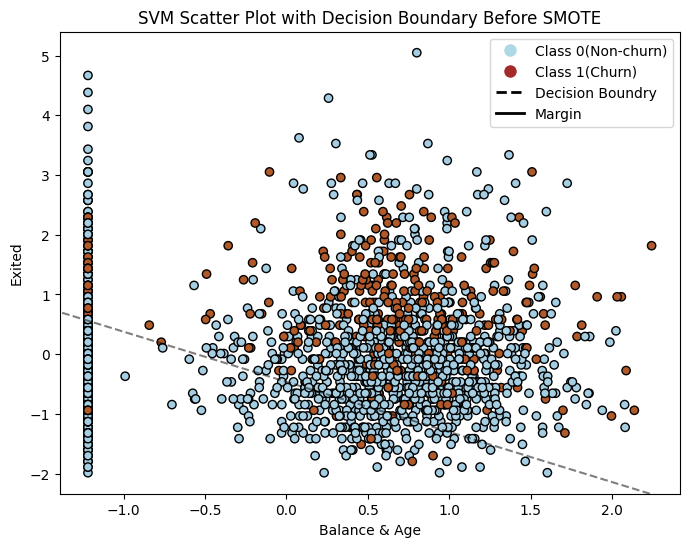

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from matplotlib.lines import Line2D

# Assuming your DataFrame is named df
# X contains features (Balance and Age), y is the target variable (Exited)
X_bs = dataEN[[ 'Balance','Age']]
y_bs = dataEN['Exited']

# Split the data into training and testing sets
X_train_bs, X_test_bs, y_train_bs, y_test_bs = train_test_split(X_bs, y_bs, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_bs = scaler.fit_transform(X_train_bs)
X_test_bs = scaler.transform(X_test_bs)

# Initialize the SVM model
svm_model = SVC(kernel='linear', random_state=42)

# Fit the model on the training data
svm_model.fit(X_train_bs, y_train_bs)

# Make predictions on the test set
y_pred_bs= svm_model.predict(X_test_bs)

# Evaluate the model
accuracy = accuracy_score(y_test_bs, y_pred_bs)
report = classification_report(y_test_bs, y_pred_bs)

print(f'Accuracy: {accuracy}')
print('Classification Report:\n', report)

# Plot the data points with different colors based on their true classes
scatter = plt.scatter(X_test_bs[:, 0], X_test_bs[:, 1], c=y_test_bs, cmap=plt.cm.Paired, edgecolors='k')

# Plot the decision boundary (hyperplane)
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# Create grid to evaluate model
xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 50),
                     np.linspace(ylim[0], ylim[1], 50))
Z = svm_model.decision_function(np.c_[xx.ravel(), yy.ravel()])

# Plot decision boundary and margins
Z = Z.reshape(xx.shape)
ax.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])

# Set labels and title
# Set the size of the plot
# Resize the plot
plt.gcf().set_size_inches(8, 6)
plt.xlabel('Balance & Age')
plt.ylabel('Exited')
plt.title('SVM Scatter Plot with Decision Boundary Before SMOTE')

# Create legend handles for '0' and '1'
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Class 0(Non-churn)', markerfacecolor='lightblue', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='Class 1(Churn)', markerfacecolor='brown', markersize=10),
                   Line2D([0], [0], color='k', linestyle='--', lw=2 ,label ='Decision Boundry'),
                Line2D([0], [0], color='k', linestyle='-', lw=2,label ='Margin')]

# Add a legend using the custom legend elements
plt.legend(handles=legend_elements)
# Resize the plot
plt.gcf().set_size_inches(8, 6)

# Show the plot
plt.show()

## **SVM Classification After SMOTE**

Accuracy: 0.6999372253609542
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.70      0.71      1633
           1       0.69      0.69      0.69      1553

    accuracy                           0.70      3186
   macro avg       0.70      0.70      0.70      3186
weighted avg       0.70      0.70      0.70      3186



<ipython-input-71-064360c15a04>:51: UserWarning: The following kwargs were not used by contour: 'label'
  contour =ax.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,


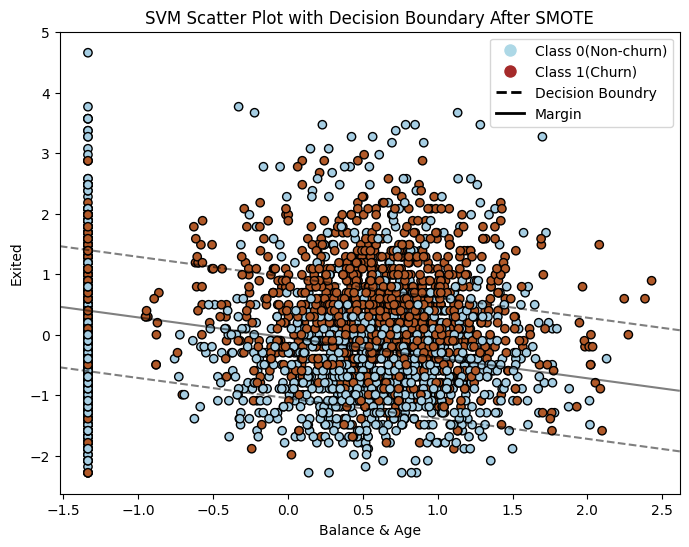

In [ ]:
# Assuming your DataFrame is named df
# X contains features (Balance and Age), y is the target variable (Exited)
from imblearn.over_sampling import SMOTE
X_as = dataEN[[ 'Balance','Age']]
y_as = dataEN['Exited']

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_as, y_as)

# Split the resampled data into training and testing sets
X_train_as, X_test_as, y_train_as, y_test_as = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_as = scaler.fit_transform(X_train_as)
X_test_as = scaler.transform(X_test_as)

# Initialize the SVM model
svm_model = SVC(kernel='linear', random_state=42)

# Fit the model on the training data
svm_model.fit(X_train_as, y_train_as)

# Make predictions on the test set
y_pred_as = svm_model.predict(X_test_as)

# Evaluate the model
accuracy = accuracy_score(y_test_as, y_pred_as)
report = classification_report(y_test_as, y_pred_as)

print(f'Accuracy: {accuracy}')
print('Classification Report:\n', report)


# Plot the data points with different colors based on their true classes
scatter = plt.scatter(X_test_as[:, 0], X_test_as[:, 1], c=y_test_as, cmap=plt.cm.Paired, edgecolors='k')

# Plot the decision boundary (hyperplane)
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# Create grid to evaluate model
xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 50),
                     np.linspace(ylim[0], ylim[1], 50))
Z = svm_model.decision_function(np.c_[xx.ravel(), yy.ravel()])

# Plot decision boundary and margins
Z = Z.reshape(xx.shape)
contour =ax.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'],label='Decision boundary and margin')

# Plot support vectors
# ax.scatter(svm.support_vectors_[:, 0], svm.support_vectors_[:, 1], s=100, linewidth=1, facecolors='none', edgecolors='k', label='Support vectors')

# Set labels and title
plt.xlabel('Balance & Age')
plt.ylabel('Exited')
plt.title('SVM Scatter Plot with Decision Boundary After SMOTE')

# Create legend handles for '0' and '1'
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Class 0(Non-churn)', markerfacecolor='lightblue', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='Class 1(Churn)', markerfacecolor='brown', markersize=10),
                   Line2D([0], [0], color='k', linestyle='--', lw=2 ,label ='Decision Boundry'),
                Line2D([0], [0], color='k', linestyle='-', lw=2,label ='Margin')]

# Add a legend using the custom legend elements
plt.legend(handles=legend_elements)
# Resize the plot
plt.gcf().set_size_inches(8, 6)
# Show the plot
plt.show()


# **5. Random Forest Classifier**

In [ ]:
random_forest = RandomForestClassifier(random_state=123)
random_forest.fit(X_train, y_train)

y_pred_rf = random_forest.predict(X_test)

# y_test_pred = random_forest.predict(X_test)
# y_train_pred = random_forest.predict(X_train_resampled)

print('*****************************Before SMOTE******************************')
print(classification_report(y_test, y_pred_rf))

random_forest.fit(X_train_res, y_train_res)

y_pred_rf_res = random_forest.predict(X_test_res)

# y_test_pred = random_forest.predict(X_test)
# y_train_pred = random_forest.predict(X_train_resampled)

print('*****************************After SMOTE******************************')
print(classification_report(y_test_res, y_pred_rf_res))


*****************************Before SMOTE******************************
              precision    recall  f1-score   support

           0       0.86      0.96      0.91      1577
           1       0.74      0.44      0.55       423

    accuracy                           0.85      2000
   macro avg       0.80      0.70      0.73      2000
weighted avg       0.84      0.85      0.83      2000

*****************************After SMOTE******************************
              precision    recall  f1-score   support

           0       0.87      0.90      0.89      1627
           1       0.89      0.87      0.88      1559

    accuracy                           0.88      3186
   macro avg       0.88      0.88      0.88      3186
weighted avg       0.88      0.88      0.88      3186



# **6. XGBoost**

In [ ]:
xgboost_model= XGBClassifier()
xgboost_model.fit(X_train, y_train)

y_pred_xg = xgboost_model.predict(X_test)

# y_test_pred = xgboost_model.predict(X_test)
# y_train_pred = xgboost_model.predict(X_train_resampled)

print('*****************************Before SMOTE*****************************')
print(classification_report(y_test, y_pred_xg))
xgboost_model.fit(X_train_res, y_train_res)

y_pred_xg_res = xgboost_model.predict(X_test_res)

# y_test_pred = xgboost_model.predict(X_test)
# y_train_pred = xgboost_model.predict(X_train_resampled)

print('*****************************After SMOTE*****************************')
print(classification_report(y_test_res, y_pred_xg_res))


*****************************Before SMOTE*****************************
              precision    recall  f1-score   support

           0       0.88      0.94      0.91      1577
           1       0.69      0.51      0.58       423

    accuracy                           0.85      2000
   macro avg       0.78      0.72      0.75      2000
weighted avg       0.84      0.85      0.84      2000

*****************************After SMOTE*****************************
              precision    recall  f1-score   support

           0       0.87      0.90      0.88      1627
           1       0.89      0.86      0.87      1559

    accuracy                           0.88      3186
   macro avg       0.88      0.88      0.88      3186
weighted avg       0.88      0.88      0.88      3186



# **7. Gradient Boosting Classifier**

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)
GradientBoostingClassifier()

y_pred_gbc = gbc.predict(X_test)
# y_test_pred = gbc.predict(X_test)
# y_train_pred = gbc.predict(X_train_resampled)

print('******************************Before SMOTE*********************************')
print(classification_report(y_test, y_pred_gbc))

gbc.fit(X_train_res, y_train_res)
GradientBoostingClassifier()

y_pred_gbc_res = gbc.predict(X_test_res)
# y_test_pred = gbc.predict(X_test)
# y_train_pred = gbc.predict(X_train_resampled)

print('******************************After SMOTE*********************************')
print(classification_report(y_test_res, y_pred_gbc_res))


******************************Before SMOTE*********************************
              precision    recall  f1-score   support

           0       0.87      0.96      0.91      1577
           1       0.77      0.46      0.58       423

    accuracy                           0.86      2000
   macro avg       0.82      0.71      0.75      2000
weighted avg       0.85      0.86      0.84      2000

******************************After SMOTE*********************************
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1627
           1       0.88      0.84      0.86      1559

    accuracy                           0.87      3186
   macro avg       0.87      0.87      0.87      3186
weighted avg       0.87      0.87      0.87      3186



## **Models Performance Summary**

## **Before SMOTE**

In [ ]:
performance_summary = pd.DataFrame({
    'MODELS':['Decision Tree','Logistic Regression','KNN','SVM','Random Forest','XGBoost','Gradient Boosting'],
    'ACCURACY':[
           accuracy_score(y_test,y_pred),
           accuracy_score(y_test,y_pred_lg),
           accuracy_score(y_test,y_pred_knn),
           accuracy_score(y_test,y_pred_svm),
           accuracy_score(y_test,y_pred_rf),
           accuracy_score(y_test,y_pred_xg),
           accuracy_score(y_test,y_pred_gbc)
          ],
    'PRECISION':[
           precision_score(y_test,y_pred),
           precision_score(y_test,y_pred_lg),
           precision_score(y_test,y_pred_knn),
           precision_score(y_test,y_pred_svm),
           precision_score(y_test,y_pred_rf),
           precision_score(y_test,y_pred_xg),
           precision_score(y_test,y_pred_gbc)
          ],
    'F1-SCORE' :[
           f1_score(y_test,y_pred),
           f1_score(y_test,y_pred_lg),
           f1_score(y_test,y_pred_knn),
           f1_score(y_test,y_pred_svm),
           f1_score(y_test,y_pred_rf),
           f1_score(y_test,y_pred_xg),
           f1_score(y_test,y_pred_gbc)
          ],
    'RECALL' :[
           recall_score(y_test,y_pred),
           recall_score(y_test,y_pred_lg),
           recall_score(y_test,y_pred_knn),
           recall_score(y_test,y_pred_svm),
           recall_score(y_test,y_pred_rf),
           recall_score(y_test,y_pred_xg),
           recall_score(y_test,y_pred_gbc)
          ]
})
performance_summary


,MODELS,ACCURACY,PRECISION,F1-SCORE,RECALL
0,Decision Tree,0.7870,0.496552,0.503497,0.510638
1,Logistic Regression,0.8060,0.620690,0.316901,0.212766
2,KNN,0.8200,0.605351,0.501385,0.427896
3,SVM,0.8505,0.819588,0.515397,0.375887
4,Random Forest,0.8480,0.737052,0.548961,0.437352
5,XGBoost,0.8470,0.686901,0.584239,0.508274
6,Gradient Boosting,0.8570,0.770751,0.576923,0.460993


## **After SMOTE**

In [ ]:
performance_summary_res = pd.DataFrame({
    'MODELS':['Decision Tree','Logistic Regression','KNN','SVM','Random Forest','XGBoost','Gradient Boosting'],
    'ACCURACY':[
           accuracy_score(y_test_res,y_pred_res),
           accuracy_score(y_test_res,y_pred_lg_res),
           accuracy_score(y_test_res,y_pred_knn_res),
           accuracy_score(y_test_res,y_pred_svm_res),
           accuracy_score(y_test_res,y_pred_rf_res),
           accuracy_score(y_test_res,y_pred_xg_res),
           accuracy_score(y_test_res,y_pred_gbc_res)
          ],
    'PRECISION':[
           precision_score(y_test_res,y_pred_res),
           precision_score(y_test_res,y_pred_lg_res),
           precision_score(y_test_res,y_pred_knn_res),
           precision_score(y_test_res,y_pred_svm_res),
           precision_score(y_test_res,y_pred_rf_res),
           precision_score(y_test_res,y_pred_xg_res),
           precision_score(y_test_res,y_pred_gbc_res)
          ],
    'F1-SCORE' :[
           f1_score(y_test_res,y_pred_res),
           f1_score(y_test_res,y_pred_lg_res),
           f1_score(y_test_res,y_pred_knn_res),
           f1_score(y_test_res,y_pred_svm_res),
           f1_score(y_test_res,y_pred_rf_res),
           f1_score(y_test_res,y_pred_xg_res),
           f1_score(y_test_res,y_pred_gbc_res)
          ],
    'RECALL' :[
           recall_score(y_test_res,y_pred_res),
           recall_score(y_test_res,y_pred_lg_res),
           recall_score(y_test_res,y_pred_knn_res),
           recall_score(y_test_res,y_pred_svm_res),
           recall_score(y_test_res,y_pred_rf_res),
           recall_score(y_test_res,y_pred_xg_res),
           recall_score(y_test_res,y_pred_gbc_res)
          ]
})

performance_summary_res


,MODELS,ACCURACY,PRECISION,F1-SCORE,RECALL
0,Decision Tree,0.828625,0.822406,0.825559,0.828736
1,Logistic Regression,0.829881,0.875831,0.813874,0.760103
2,KNN,0.847458,0.855063,0.841694,0.828736
3,SVM,0.866290,0.904354,0.856081,0.812700
4,Random Forest,0.883867,0.893970,0.879400,0.865298
5,XGBoost,0.878531,0.891711,0.873322,0.855677
6,Gradient Boosting,0.866918,0.883705,0.860434,0.838358


# **Comparison of Models**

# **Accuracy & F1-score before SMOTE**

<ipython-input-43-928be1cce0f9>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='MODELS', y='ACCURACY', data=performance_summary ,palette=custom_palette,ax=ax[0] )
<ipython-input-43-928be1cce0f9>:4: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.
  sns.barplot(x='MODELS', y='ACCURACY', data=performance_summary ,palette=custom_palette,ax=ax[0] )
<ipython-input-43-928be1cce0f9>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='MODELS', y='F1-SCORE', data=performance_summary ,palette=custom_palette,ax=ax[1] )
<ipython-input-43-928be1cce0f9>:5: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.
  sn

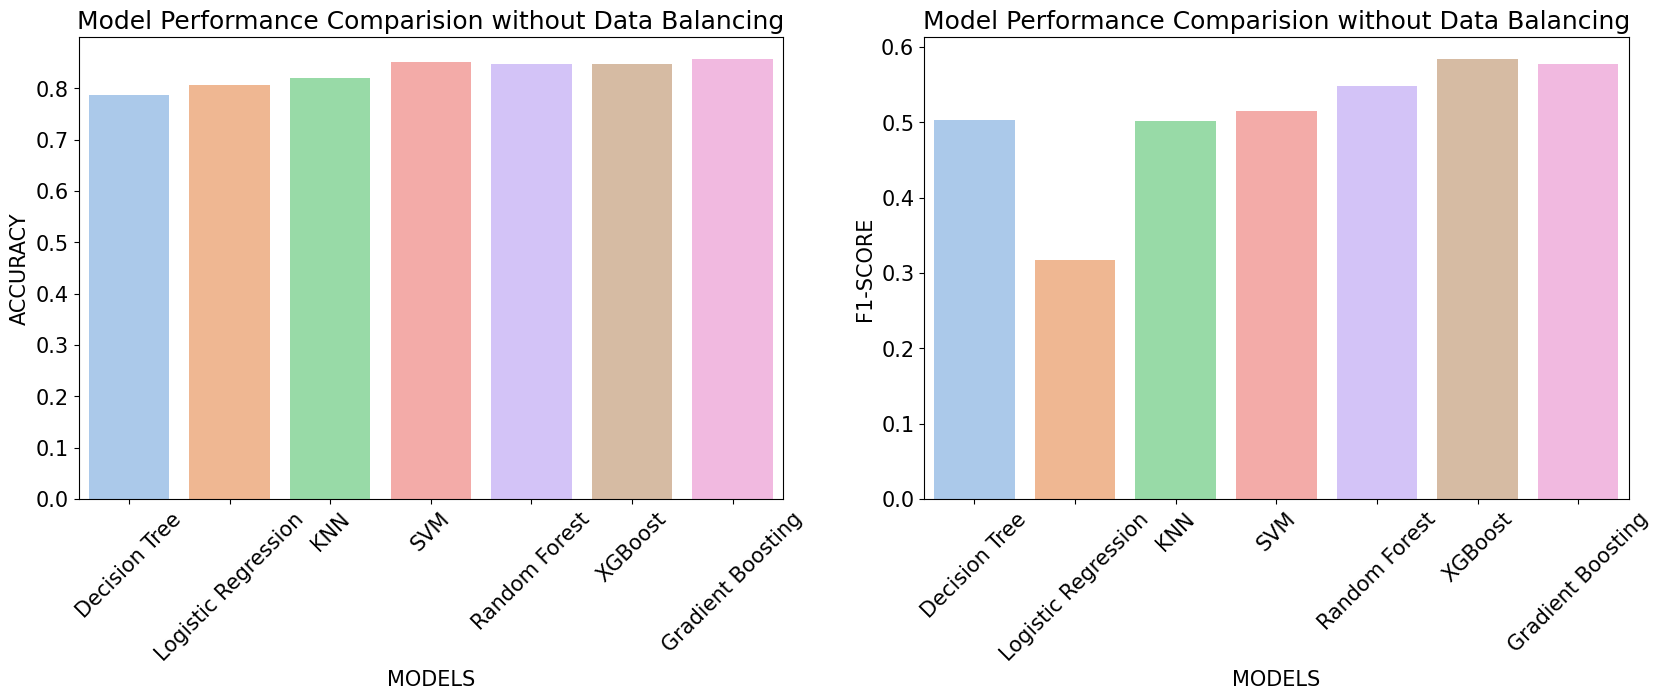

In [ ]:
custom_palette = sns.color_palette("pastel")  # Example palette
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

sns.barplot(x='MODELS', y='ACCURACY', data=performance_summary ,palette=custom_palette,ax=ax[0] )
sns.barplot(x='MODELS', y='F1-SCORE', data=performance_summary ,palette=custom_palette,ax=ax[1] )

# Rotate x-axis labels for better visibility
for col in ax:
    col.set_xticklabels(col.get_xticklabels(), rotation=45)

# Set font size for x-axis and y-axis tick labels for each subplot
for col in ax:
    col.tick_params(axis='x', labelsize=15)
    col.tick_params(axis='y', labelsize=15)
    col.set_xlabel(col.get_xlabel(), fontsize=15)
    col.set_ylabel(col.get_ylabel(), fontsize=15)
    col.set_title('Model Performance Comparision without Data Balancing', fontsize=18)  # Set title for each subplot

plt.show()

# **Accuracy & F1-score (After SMOTE)**

<ipython-input-44-f77fbf3cf7ba>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='MODELS', y='ACCURACY', data=performance_summary_res ,palette=custom_palette,ax=ax[0] )
<ipython-input-44-f77fbf3cf7ba>:4: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.
  sns.barplot(x='MODELS', y='ACCURACY', data=performance_summary_res ,palette=custom_palette,ax=ax[0] )
<ipython-input-44-f77fbf3cf7ba>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='MODELS', y='F1-SCORE', data=performance_summary_res ,palette=custom_palette,ax=ax[1] )
<ipython-input-44-f77fbf3cf7ba>:5: UserWarning: The palette list has more values (10) than needed (7), which may not be in

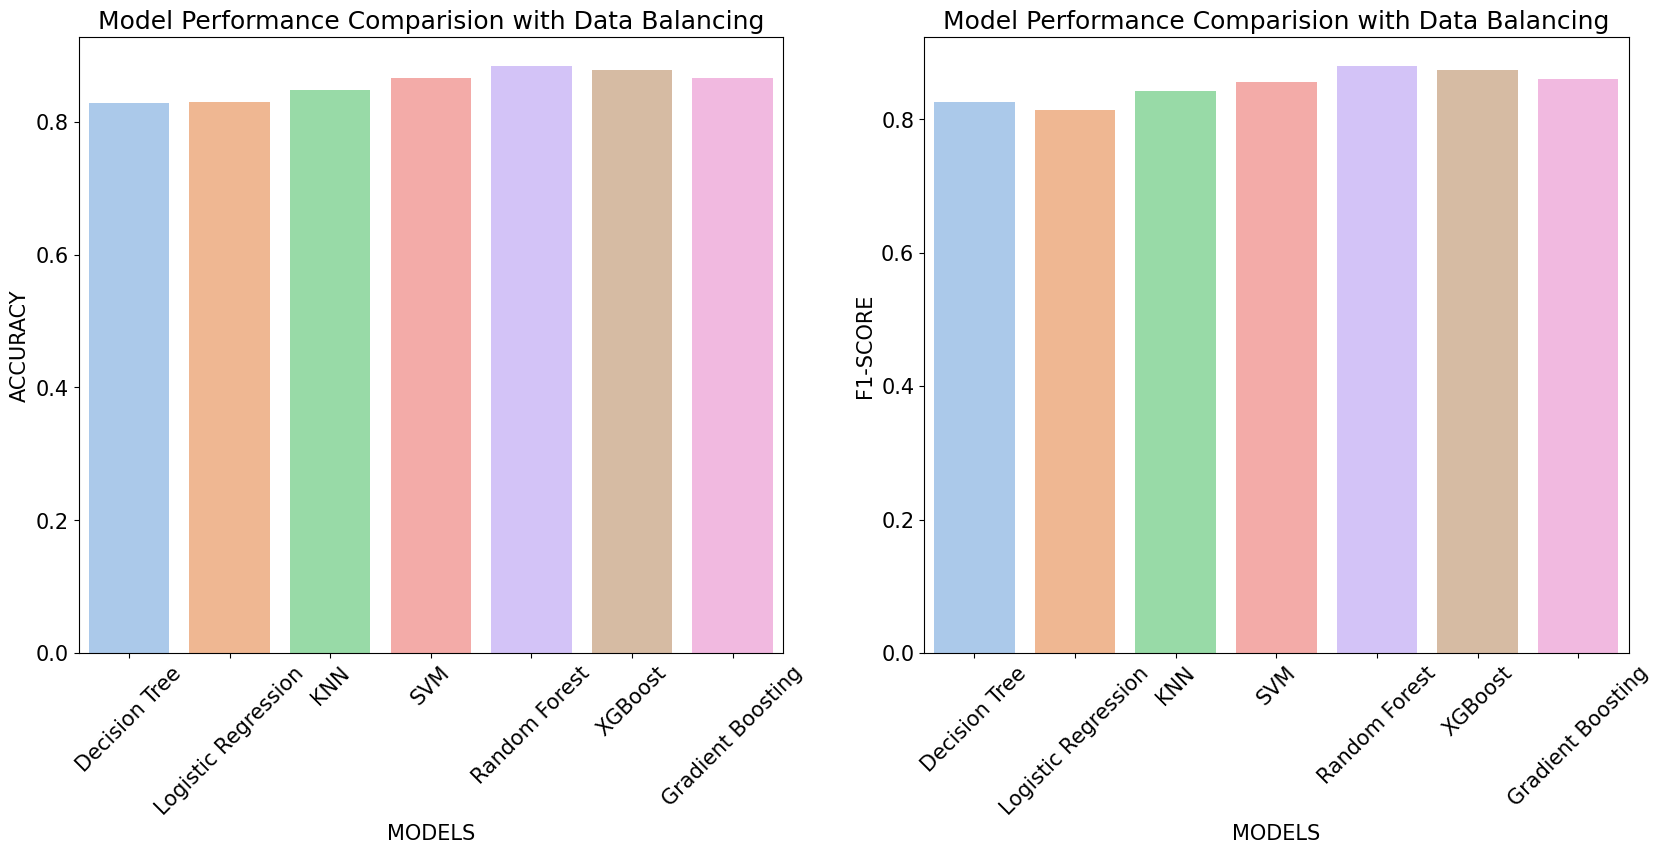

In [ ]:
custom_palette = sns.color_palette("pastel")  # Example palette
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

sns.barplot(x='MODELS', y='ACCURACY', data=performance_summary_res ,palette=custom_palette,ax=ax[0] )
sns.barplot(x='MODELS', y='F1-SCORE', data=performance_summary_res ,palette=custom_palette,ax=ax[1] )

# Rotate x-axis labels for better visibility
for col in ax:
    col.set_xticklabels(col.get_xticklabels(), rotation=45)

# Set font size for x-axis and y-axis tick labels for each subplot
for col in ax:
    col.tick_params(axis='x', labelsize=15)
    col.tick_params(axis='y', labelsize=15)
    col.set_xlabel(col.get_xlabel(), fontsize=15)
    col.set_ylabel(col.get_ylabel(), fontsize=15)
    col.set_title('Model Performance Comparision with Data Balancing', fontsize=18)  # Set title for each subplot

plt.show()

# **ROC Curve**

In [ ]:
# Create an empty DataFrame
auc_df = pd.DataFrame(columns=['MODELS', 'AUC'])


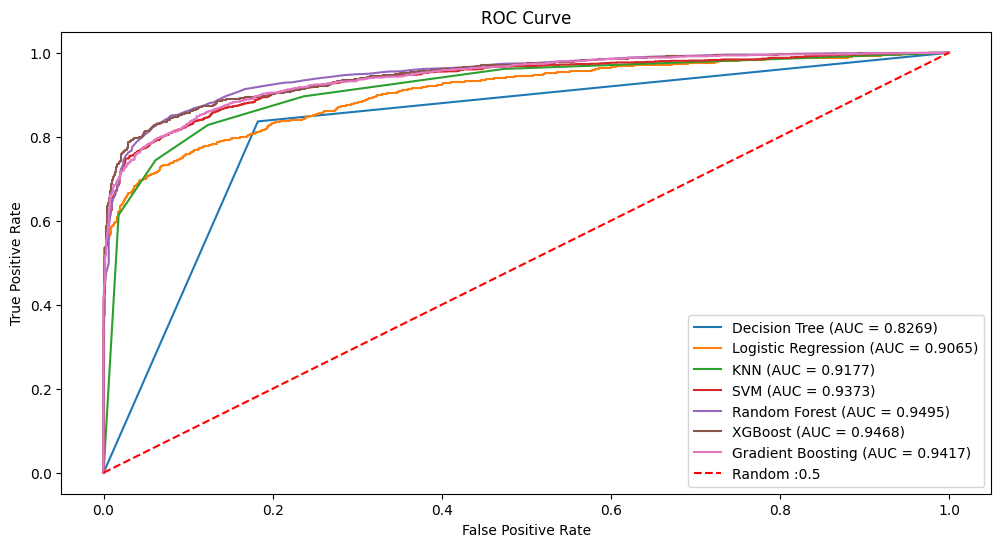

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc
# Initialize classifiers
classifiers = {
    'Decision Tree': DecisionTreeClassifier(),
    'Logistic Regression': LogisticRegression(),
    'KNN': KNeighborsClassifier(),
    'SVM': SVC(probability=True),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(),
    'Gradient Boosting': GradientBoostingClassifier()
}
data_list = []
# Plot ROC curves for each classifier
plt.figure(figsize=(12, 6))
for name, clf in classifiers.items():
    clf.fit(X_train_res, y_train_res)
    y_pred_proba = clf.predict_proba(X_test_res)[:, 1]
    fpr, tpr, _ = roc_curve(y_test_res, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    data_list.append({'Model': name, 'AUC': roc_auc})
    plt.plot(fpr, tpr, label='%s (AUC = %0.4f)' % (name, roc_auc))

auc_df = pd.DataFrame(data_list)
plt.plot([0, 1], [0, 1], linestyle='--', color='r', label='Random :0.5')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
auc_df_sorted = auc_df.sort_values(by='AUC', ascending=False)
# Style the DataFrame to bold the text for the first value in the 'Model' column
auc_df_sorted = auc_df_sorted.style.apply(lambda x: ['font-weight: bold' if i == 0 else '' for i, _ in enumerate(x)], axis=1)
# Style the first row to bold text
# Define a function to make the first row bold

auc_df_sorted

,Model,AUC
4,Random Forest,0.949477
5,XGBoost,0.946831
6,Gradient Boosting,0.941709
3,SVM,0.937290
2,KNN,0.917745
1,Logistic Regression,0.906460
0,Decision Tree,0.826945


# **Final Model Evaluation**

# **Random Forest**

In [ ]:
Selected_classifier = RandomForestClassifier(random_state = 0)
Selected_classifier.fit(X_train_res, y_train_res)
# Predict the Test set results
y_pred_fitted = Selected_classifier.predict(X_test_res)
#Evaluate Model Results on Test Set:
from sklearn.metrics import precision_score,recall_score,f1_score
acc = accuracy_score(y_test_res, y_pred_fitted )
prec = precision_score(y_test_res, y_pred_fitted )
rec = recall_score(y_test_res, y_pred_fitted )
f1 = f1_score(y_test_res, y_pred_fitted )

results = pd.DataFrame([['Random Forest', acc, prec, rec, f1, ]],columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score',])
print (results)

           Model  Accuracy  Precision    Recall  F1 Score
0  Random Forest  0.884181   0.894562  0.865298  0.879687


## **Confusion Matrix**

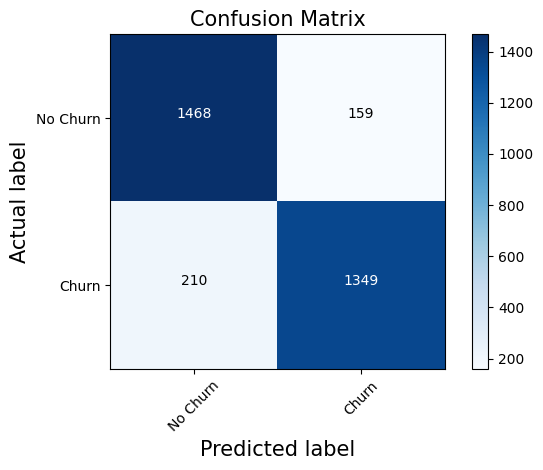

In [ ]:
import itertools
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    """
    This function plots a confusion matrix.

    Parameters:
        cm (array-like): Confusion matrix as returned by sklearn.metrics.confusion_matrix.
        classes (list): List of class names, e.g., ['Class 0', 'Class 1'].
        title (str): Title for the plot.
        cmap (matplotlib colormap): Colormap for the plot.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title ,fontsize=15)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.0f'
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Actual label',fontsize=15)
    plt.xlabel('Predicted label',fontsize=15)
    plt.tight_layout()



# Get the confusion matrix
cm = confusion_matrix(y_test_res, (y_pred_fitted > 0.5))

# Plot the confusion matrix
class_names = ['No Churn', 'Churn'] # positive class should come the last
plot_confusion_matrix(cm, class_names)

## **ROC Curve**

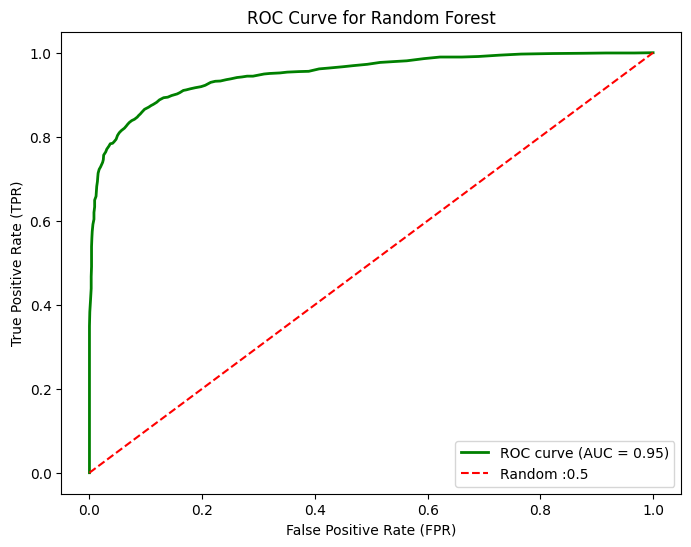

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Assuming rf_model is your trained Random Forest classifier
# and X_test_res is your test set

# Predict probabilities of the positive class
y_pred_proba = Selected_classifier.predict_proba(X_test_res)[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test_res, y_pred_proba)

# Compute AUC score
auc_score = roc_auc_score(y_test_res, y_pred_proba)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='g', lw=2, label=f'ROC curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--',label='Random :0.5')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for Random Forest')
plt.legend(loc='lower right')
# plt.grid(false)
plt.show()


## **k-Fold Cross-Validation**:



In [ ]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = Selected_classifier, X = X_train_res, y = y_train_res, cv = 10)
print("Random Forest Classifier Accuracy: %0.2f (+/- %0.2f)"  % (accuracies.mean(),  accuracies.std() * 2))

Random Forest Classifier Accuracy: 0.89 (+/- 0.01)


In [ ]:
pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 5.1 MB/s eta 0:00:00


In [ ]:
import shap

# Initialize the JS visualization for SHAP plots
shap.initjs()

# Create a SHAP explainer object for the Random Forest model
explainer = shap.TreeExplainer(Selected_classifier)

# Calculate SHAP values
shap_values = explainer.shap_values(X_test_res)

# Display all columns in the SHAP summary plot
shap.summary_plot(shap_values, X_test_res, max_display=len(X.columns))


## **SHAP Values**

New shape of SHAP values matrix: (3186, 13)


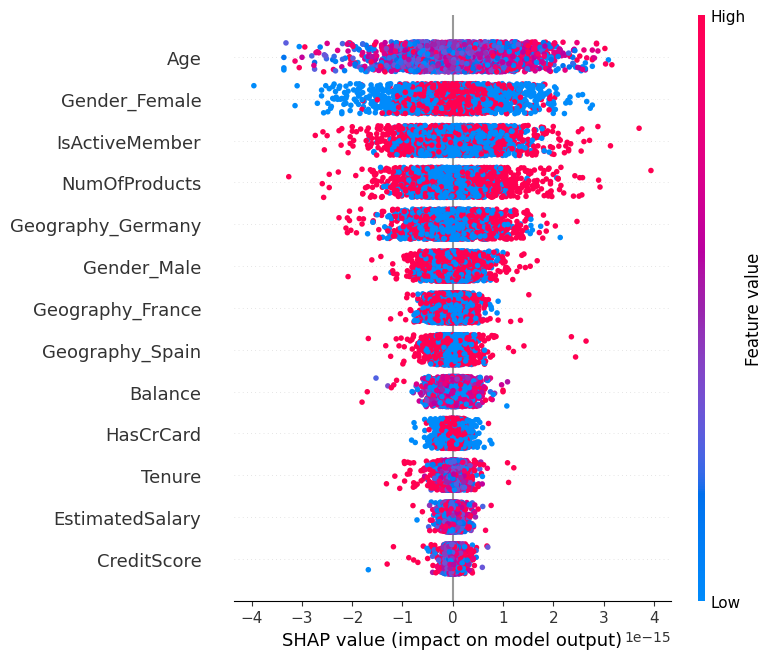

In [ ]:
import shap
import matplotlib.pyplot as plt

# Create a SHAP explainer object for the Random Forest model
explainer = shap.Explainer(Selected_classifier)

# Calculate SHAP values
shap_values = explainer.shap_values(X_test_res)

# Aggregate the two sets of SHAP values (e.g., by taking the mean)
shap_values_aggregated = np.mean(shap_values, axis=2)  # or np.sum(shap_values, axis=2)

# Reshape the aggregated SHAP values matrix to match the shape of the input data matrix
shap_values_reshaped = shap_values_aggregated.reshape(shap_values_aggregated.shape[0], shap_values_aggregated.shape[1])


# Check the new shape of SHAP values
print("New shape of SHAP values matrix:", shap_values_reshaped.shape)

# Convert NumPy array to pandas DataFrame
X_test_res_df = pd.DataFrame(X_test_res, columns=X.columns)
# Plot SHAP summary plot
shap.summary_plot(shap_values_reshaped, X_test_res_df)



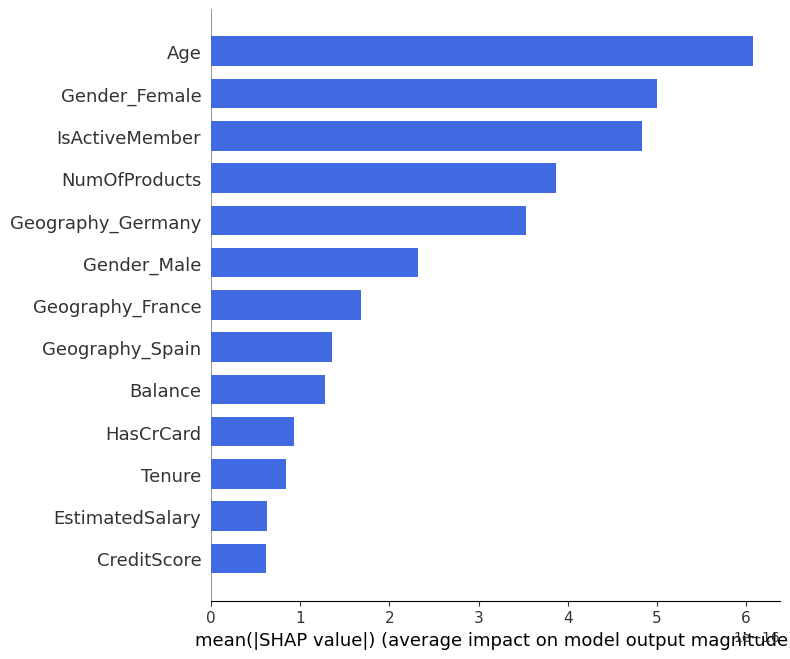

In [ ]:
shap.summary_plot(shap_values_reshaped, X_test_res_df, plot_type="bar", color="royalblue", alpha=0.7)


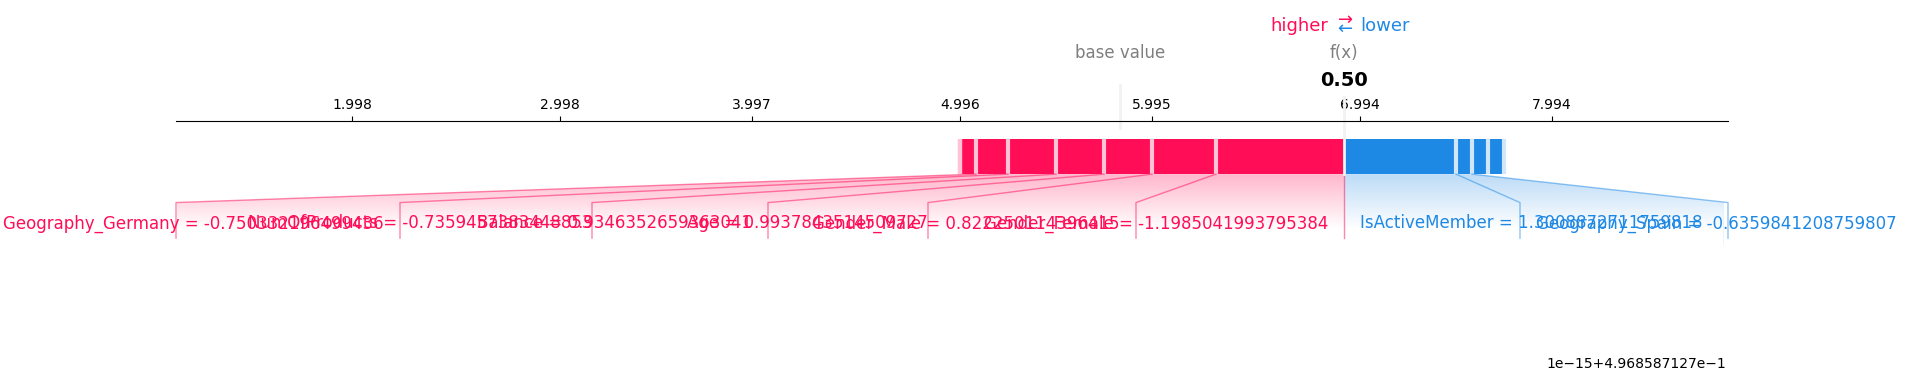

In [ ]:
shap.plots.force(explainer.expected_value[0], shap_values_reshaped[0], X_test_res_df.iloc[0], matplotlib = True)


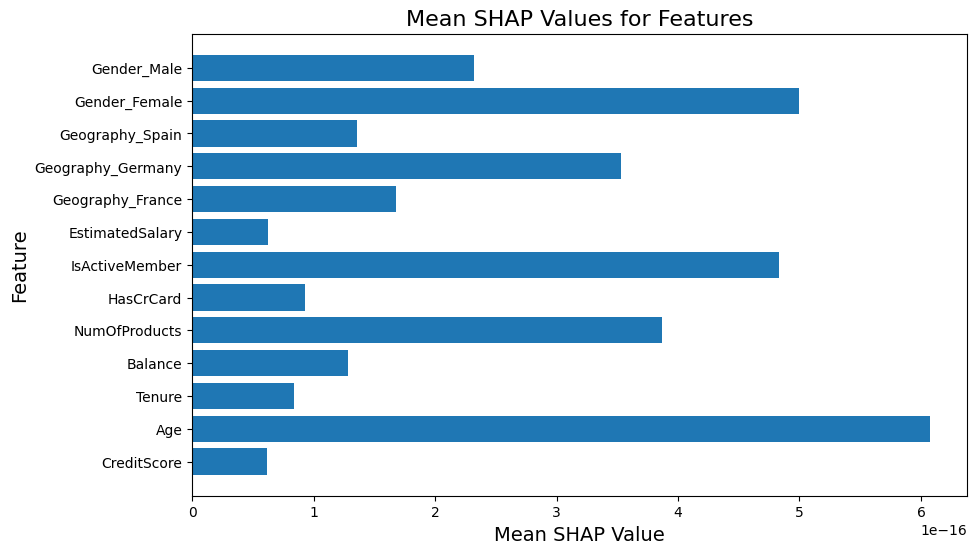

In [ ]:
# Calculate the mean SHAP values for each feature
mean_shap_values = np.abs(shap_values_reshaped).mean(axis=0)

# Create a bar plot for SHAP values
plt.figure(figsize=(10, 6))
plt.barh(X_test_res_df.columns, mean_shap_values)

# Set labels and title
plt.xlabel('Mean SHAP Value', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.title('Mean SHAP Values for Features', fontsize=16)

# Show the plot
plt.show()

# **Feature Importance**

<ipython-input-127-e66325cf1cbb>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_df, palette=custom_palette)


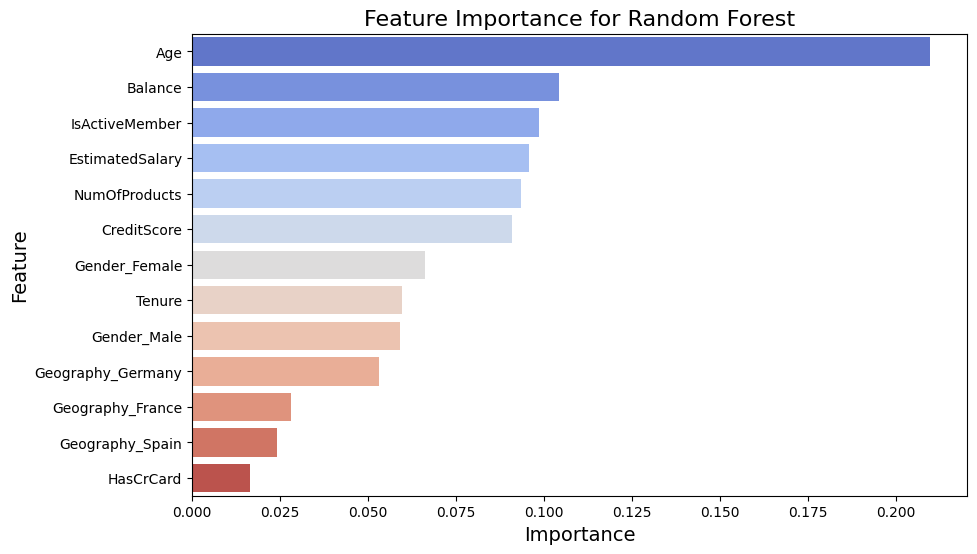

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Extract feature importances from the Random Forest model
feature_importance = Selected_classifier.feature_importances_

# Create a DataFrame to hold feature names and their importances
feature_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})

# Sort the DataFrame by importance in descending order
feature_df = feature_df.sort_values(by='Importance', ascending=False)

# Create a custom color palette
custom_palette = sns.color_palette("coolwarm", n_colors=len(feature_df))

# Create the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_df, palette=custom_palette)

# Set labels and title
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.title('Feature Importance for Random Forest', fontsize=16)

# Show the plot
plt.show()


# **Model Impovement**

In [ ]:
# input different # of trees n_estimators for random forrest to GridSearchCV
grid_values = {'n_estimators': [5, 10,15,20,25,30,35,40,45,50,55,60],
# input two different criterion'gini','entropy' for random forrest to GridSearchCV
               'criterion':['gini','entropy'],
# input different # of  min_samples_split for random forrest to GridSearchCV
               'min_samples_split': [1e-20, 5e-20, 1e-10, 5e-10, 1e-5, 5e-5, 1e-2, 5e-2],
              }
#INitializing GridSearchCV using Random forrest Classifier, CV=5 and roc_auc as metrics
Grid_classifier_rf = GridSearchCV(Selected_classifier,grid_values,cv=10, scoring='accuracy')

In [ ]:
Grid_classifier_rf.fit(X_train_res,y_train_res)

GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=0),
             param_grid={'criterion': ['gini', 'entropy'],
                         'min_samples_split': [1e-20, 5e-20, 1e-10, 5e-10,
                                               1e-05, 5e-05, 0.01, 0.05],
                         'n_estimators': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50,
                                          55, 60]},
             scoring='accuracy')

In [ ]:
Grid_classifier_rf.best_params_

{'criterion': 'entropy', 'min_samples_split': 1e-20, 'n_estimators': 50}

In [ ]:
Grid_classifier_rf.best_score_

0.8933281004709578

In [ ]:
Grid_classifier_rf.best_estimator_

RandomForestClassifier(criterion='entropy', min_samples_split=1e-20,
                       n_estimators=50, random_state=0)

In [ ]:
Tuned_classifier = RandomForestClassifier(criterion  = 'gini', min_samples_split = 1e-20, n_estimators =  55)

In [ ]:
Tuned_classifier.fit(X_train_res,y_train_res)

RandomForestClassifier(min_samples_split=1e-20, n_estimators=55)

# **Future Predictions**

### Make predictions on test data by showing first 60 predicted values:

In [ ]:
y_pred_fp = Tuned_classifier.predict(X_test_res)
y_pred_fp[0:60]

array([0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1,
       0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1])

### Compare the actuL & predicted values of Exited column for tuned model:



In [ ]:
df_comp = pd.DataFrame({'Actual': y_test_res, 'Predicted': y_pred_fp})
df_comp.head(20)

,Actual,Predicted
8901,0,0
9248,0,0
15313,1,1
11440,1,1
6578,0,0
4631,0,0
5023,0,0
14466,1,1
12050,1,1
14716,1,1



### **Accuracy & Confusion matrix for Tuned Random Forest Model:**

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score,precision_score,recall_score,f1_score
#Evaluate Model Results on Test Set:

acc = accuracy_score(y_test_res, y_pred_fp )
prec = precision_score(y_test_res, y_pred_fp )
rec = recall_score(y_test_res, y_pred_fp )
f1 = f1_score(y_test_res, y_pred_fp )

results = pd.DataFrame([['Random Forest', acc, prec, rec, f1, ]],columns = ['Model', 'Tuned Accuracy', 'Tuned Precision', 'Tuned Recall', 'Tuned F1 Score',])
print (results)


           Model  Tuned Accuracy  Tuned Precision  Tuned Recall  \
0  Random Forest        0.881042         0.889696      0.864015   

   Tuned F1 Score  
0        0.876668  


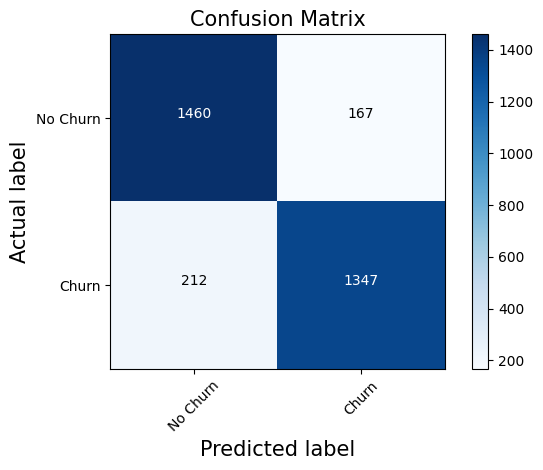

In [ ]:
# Get the confusion matrix
cm = confusion_matrix(y_test_res, y_pred_fp)

# Plot the confusion matrix
class_names = ['No Churn', 'Churn'] # positive class should come the last
plot_confusion_matrix(cm, class_names)